## Data Storytelling
The hospital readmission dataset consists entirely of either integer or categorical variables. The goal of this project is to be able to predict if a patient would be readmitted to the hospital within 30 days following hospital discharge. The labels privided with the dataset classify each encounter either with being readmitted within 30 days (`<30`), being readmitted in more that 30 days (`>30`) or no readmission (`NO`). 
The goal of this report is to explore the dataset, visualize interesting trends, and to identify variables relevant for the prediction of readmission.

In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import Imputer
import sys
sys.path.append('icd9')
from icd9 import ICD9
import re
import pickle
import seaborn as sns
import pylab
from scipy.cluster.hierarchy import dendrogram, linkage
sns.set()

In [2]:
with open('clean_data/df.pkl', 'rb') as f:
        df = pickle.load(f)
with open('clean_data/df_labels.pkl', 'rb') as f:
        df_labels = pickle.load(f)

In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,level_4_diag_1_na,level_5_diag_1_na,level_2_diag_2_na,level_3_diag_2_na,level_4_diag_2_na,level_5_diag_2_na,level_2_diag_3_na,level_3_diag_3_na,level_4_diag_3_na,level_5_diag_3_na
0,2278392,8222157,3,1,0,0,0,1,1,0,...,0,0,1,1,1,1,1,1,1,1
1,149190,55629189,3,1,1,1,1,7,3,0,...,0,0,0,0,0,0,0,0,0,0
2,64410,86047875,1,1,2,1,1,7,2,0,...,0,0,0,0,0,0,0,0,0,0
3,500364,82442376,3,2,3,1,1,7,2,0,...,0,0,0,0,0,0,0,0,0,0
4,16680,42519267,3,2,4,1,1,7,1,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'race_na', 'gender_na', 'admission_type_id_na',
       'discharge_disposition_id_na', 'admission_source_id_na',
       'medical_

What variables are correllated with the `readmitted` variable?

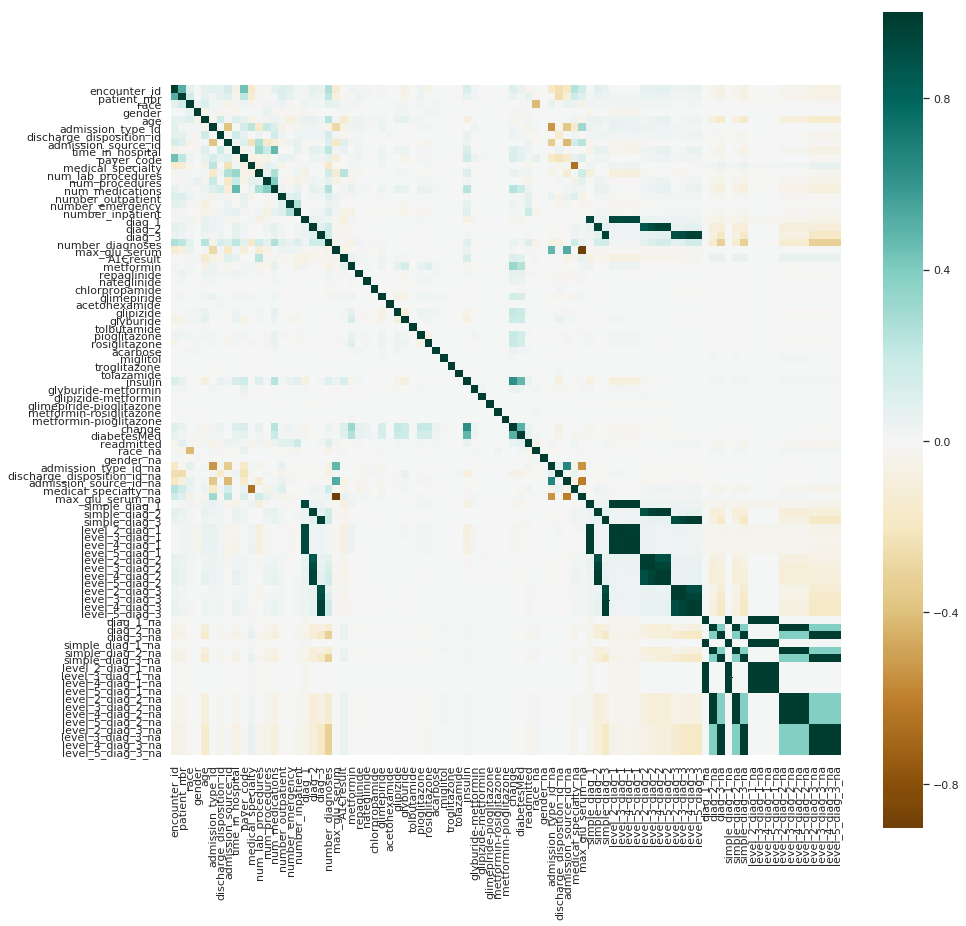

In [5]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        square=True,
        ax=ax,
        center=0,
        cmap='BrBG')

It appears that overall there were showed a strong correlation with the label. The variables with the stronges correlation were `number _outpatient`, `number_emergency`, `number_inpatient`, `number_diagnoses`. Next, I am going to explore the hierarchical clustering of the correlation matrix.

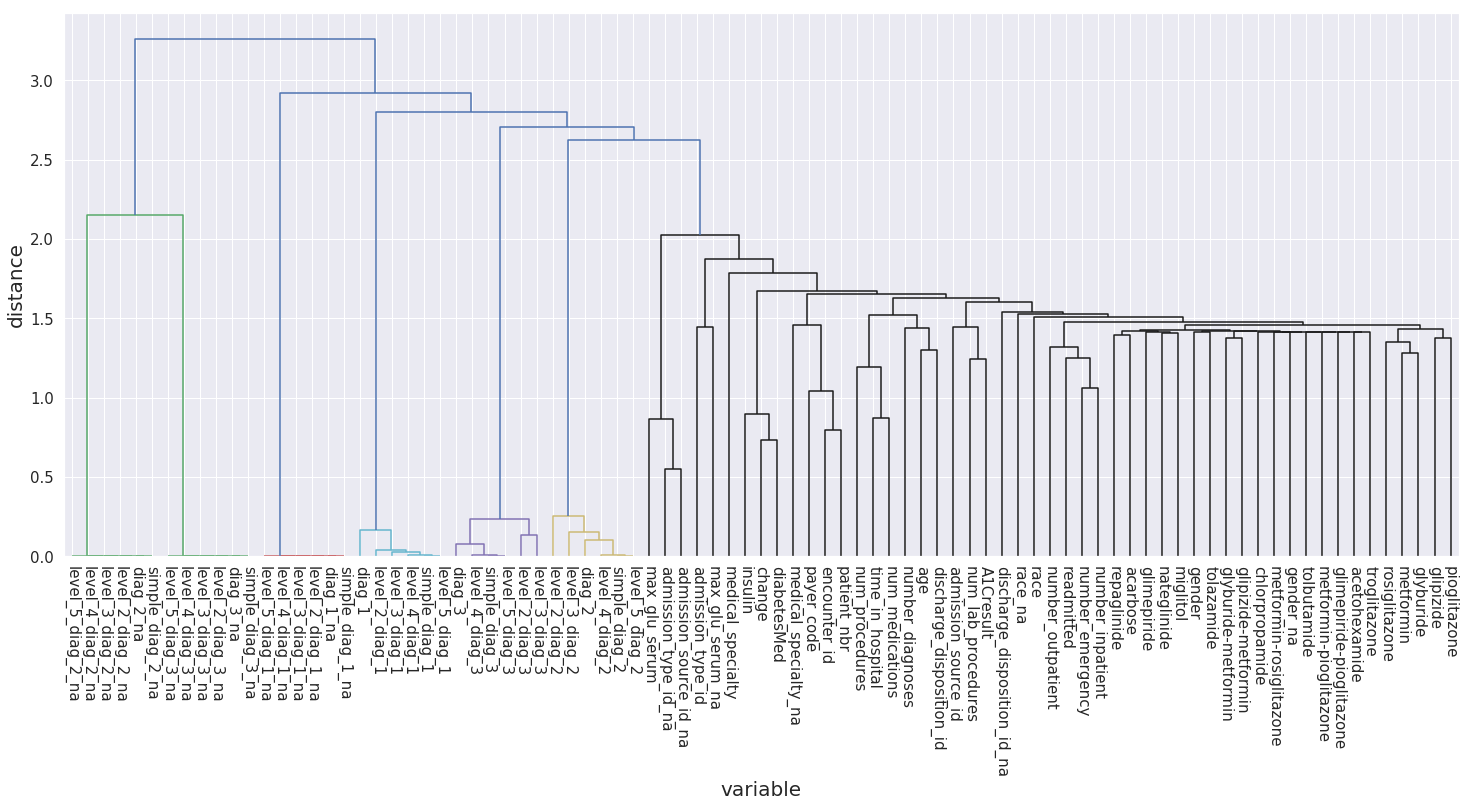

In [6]:
Z = linkage(corr, 'average')
plt.figure(figsize=(25, 10))
labelsize=20
ticksize=15
plt.xlabel('variable', fontsize=labelsize)
plt.ylabel('distance', fontsize=labelsize)
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels = corr.columns
)
pylab.yticks(fontsize=ticksize)
pylab.xticks(rotation=-90, fontsize=ticksize)
plt.show()

The hierarchical clustering leads to the same list of closely correlated variables. Since the correlation heatmap showing all the variables was very dense and hard to interpret, in the next step I will show the correlation matrix with only top positively and negatively correlated variables.

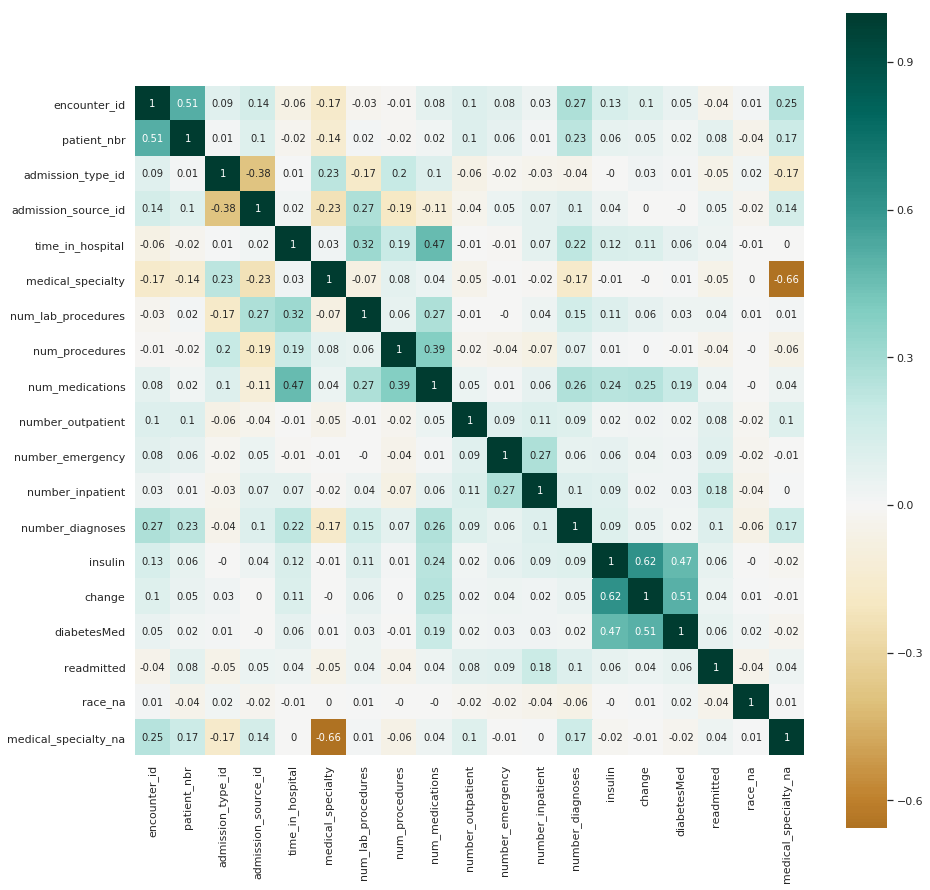

In [7]:
corr_thresh = 0.035
df_correlated = df.loc[:, ((corr.readmitted.sort_values()<-corr_thresh) | (corr.readmitted.sort_values()>corr_thresh))]
corr_high = df_correlated.corr()
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(corr_high, 
        xticklabels=corr_high.columns,
        yticklabels=corr_high.columns,
        square=True,
        ax=ax,
        center=0,
        cmap='BrBG',
        annot=corr_high.round(2))

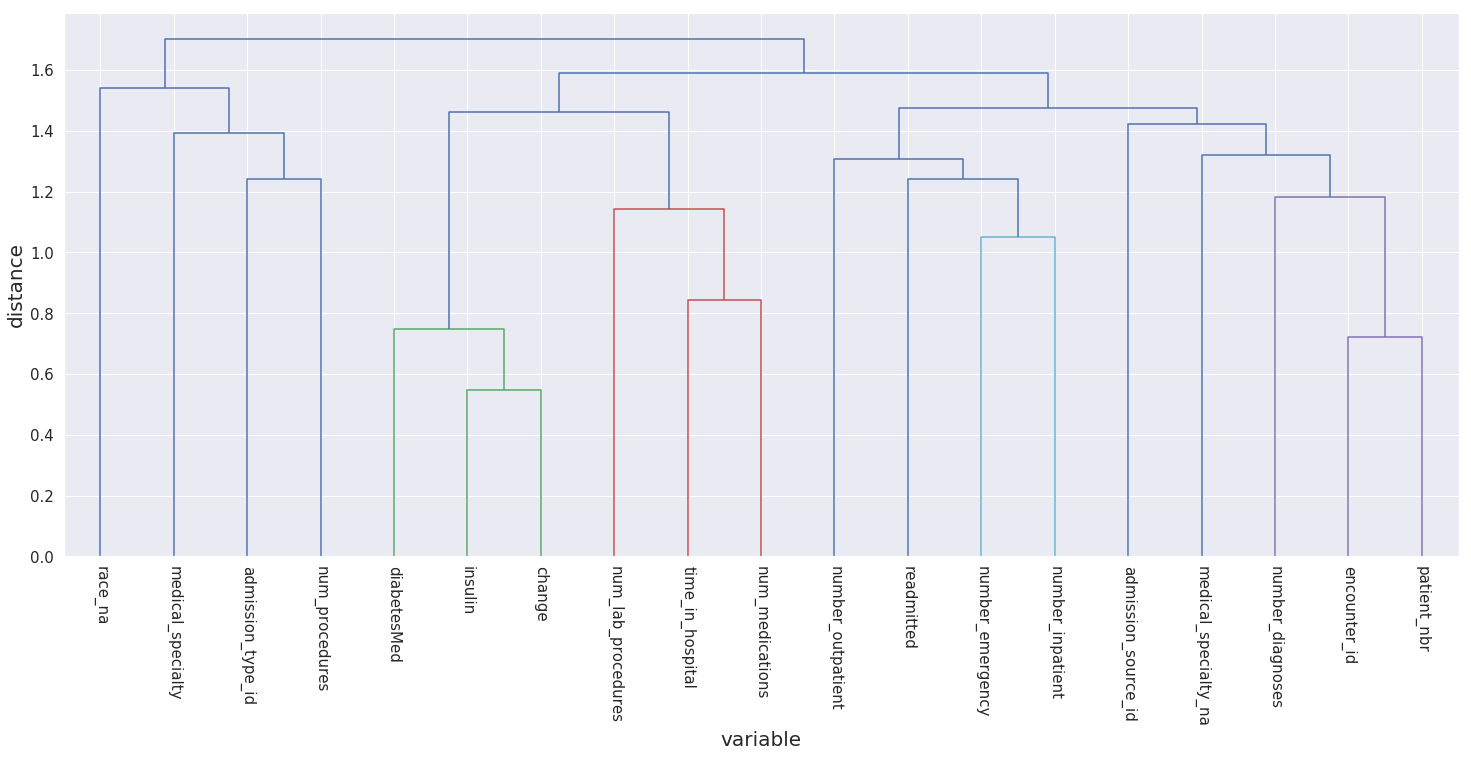

In [8]:
Z_high = linkage(corr_high, 'average')
plt.figure(figsize=(25, 10))
labelsize=20
ticksize=15
#plt.title('Hierarchical Clustering Dendrogram for '+index, fontsize=labelsize)
plt.xlabel('variable', fontsize=labelsize)
plt.ylabel('distance', fontsize=labelsize)
dendrogram(
    Z_high,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels = corr_high.columns
)
pylab.yticks(fontsize=ticksize)
pylab.xticks(rotation=-90, fontsize=ticksize)
plt.show()

In [9]:
def frequencies_by_groups(df, groups, df_labels):
    by_groups = df[groups].groupby(groups).size()
    by_groups.name = 'value_count'
    by_groups = by_groups.reset_index()
    by_group1_sum = df[groups].groupby(groups[0]).size()
    by_group1_sum.name = 'sum_by_{}'.format(groups[0])
    by_group1_sum = by_group1_sum.reset_index()
    by_groups_merged = by_groups.merge(by_group1_sum)
    by_groups_merged['frequency'] = by_groups_merged.value_count.divide(by_groups_merged['sum_by_{}'.format(groups[0])])
    by_groups_merged.readmitted = by_groups_merged.readmitted.map(dict(zip(range(len(df_labels['readmitted'])), df_labels['readmitted'])))
    if groups[0] in df_labels.keys():
        by_groups_merged[groups[0]] = by_groups_merged[groups[0]].map(dict(zip(range(len(df_labels[groups[0]])), df_labels[groups[0]])))
    return by_groups_merged

Next, I am going to explore how the frequencies of individual variables are distributed across the `readmitted`categories. 

In [10]:
x_columns = [
 'race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'race_na',
 'gender_na',
 'admission_type_id_na',
 'discharge_disposition_id_na',
 'admission_source_id_na',
 'medical_specialty_na',
 'diag_1_na',
 'diag_2_na',
 'diag_3_na'
]

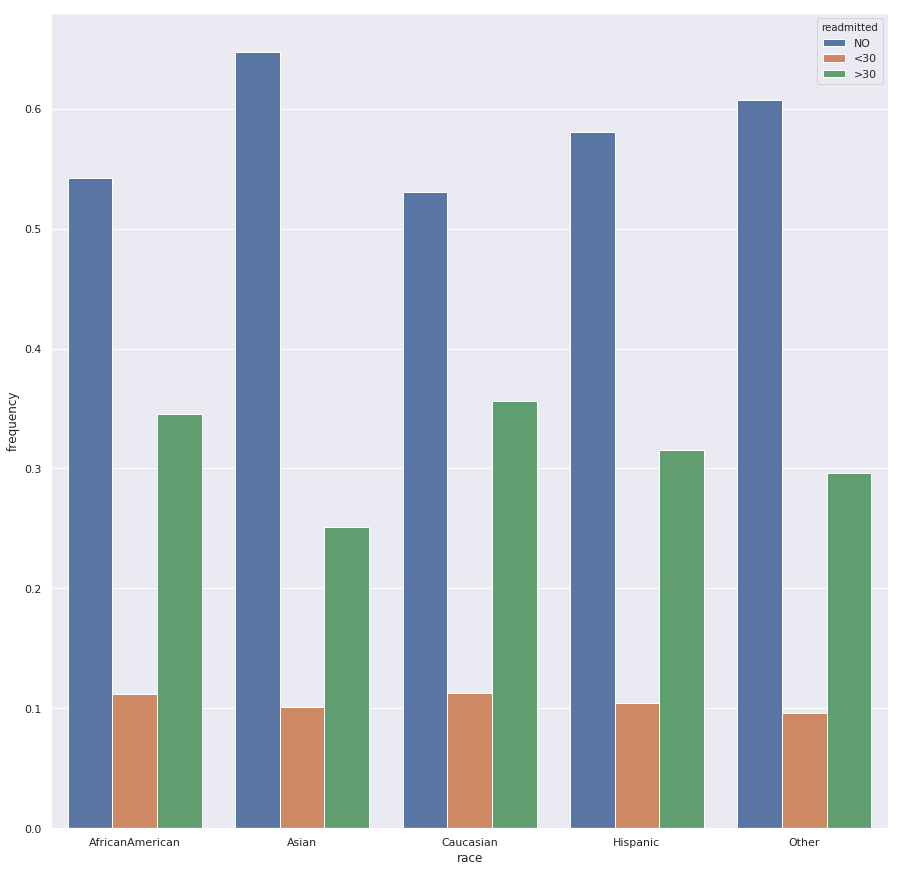

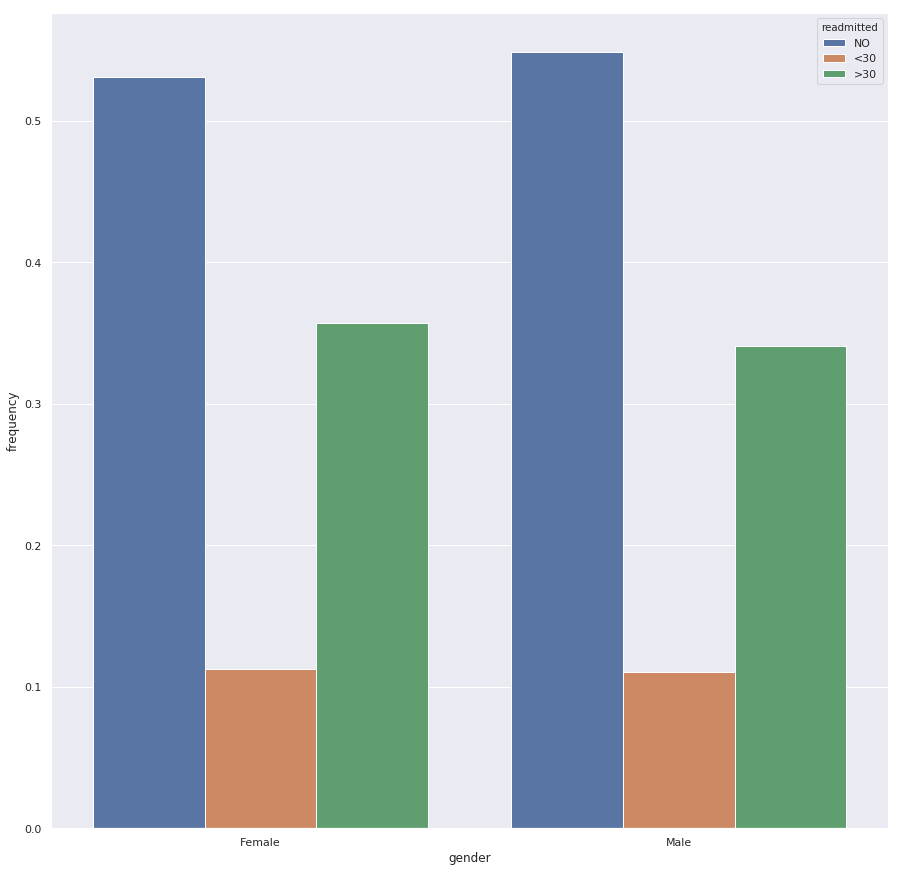

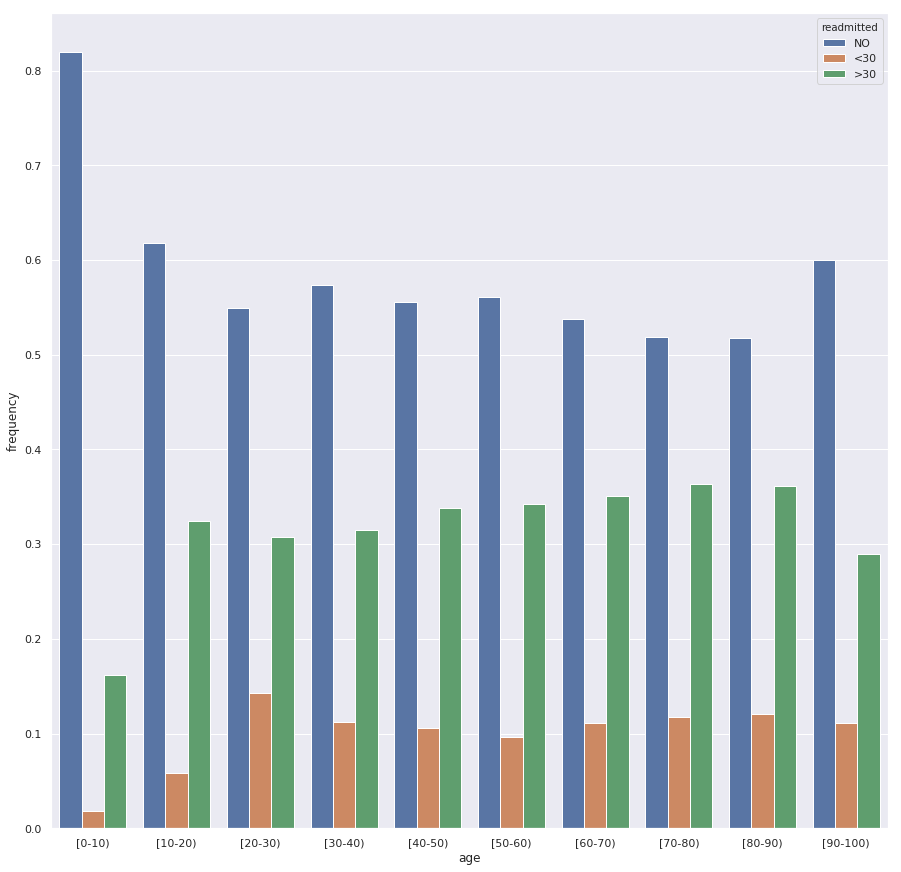

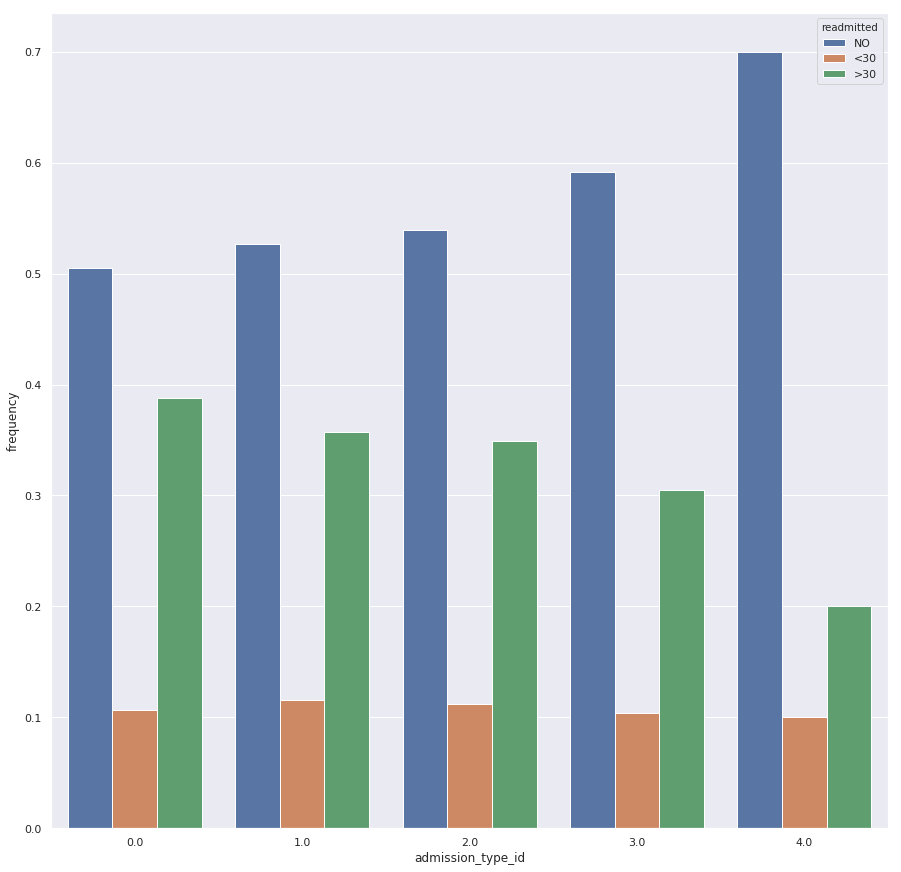

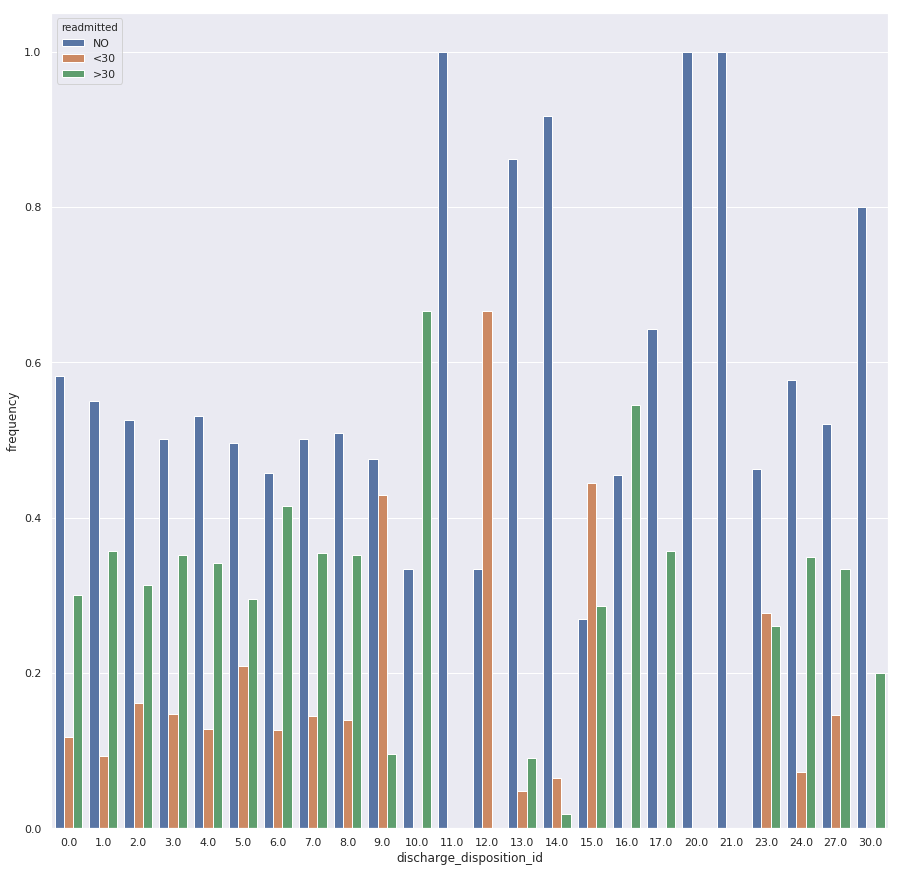

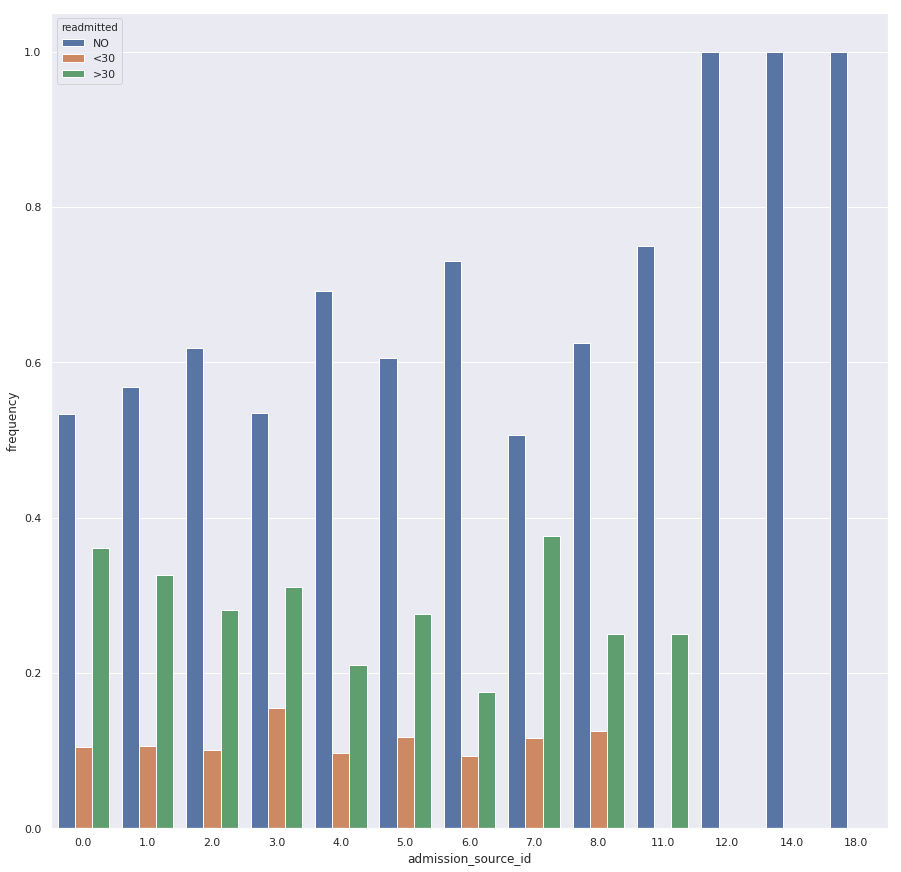

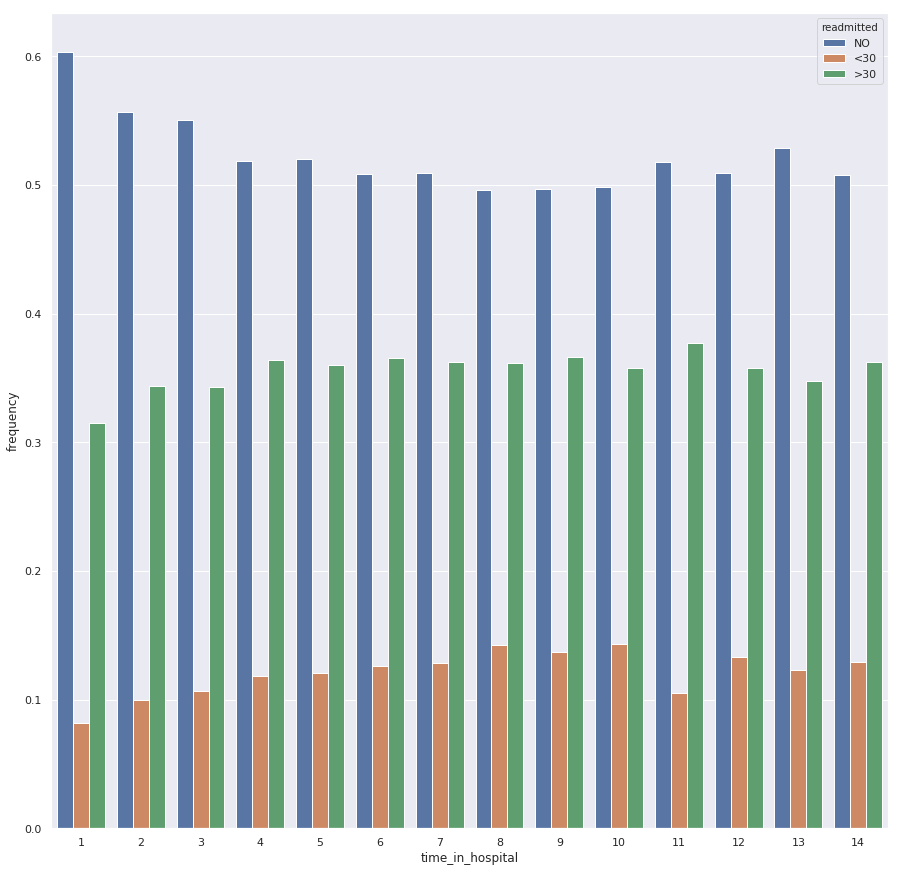

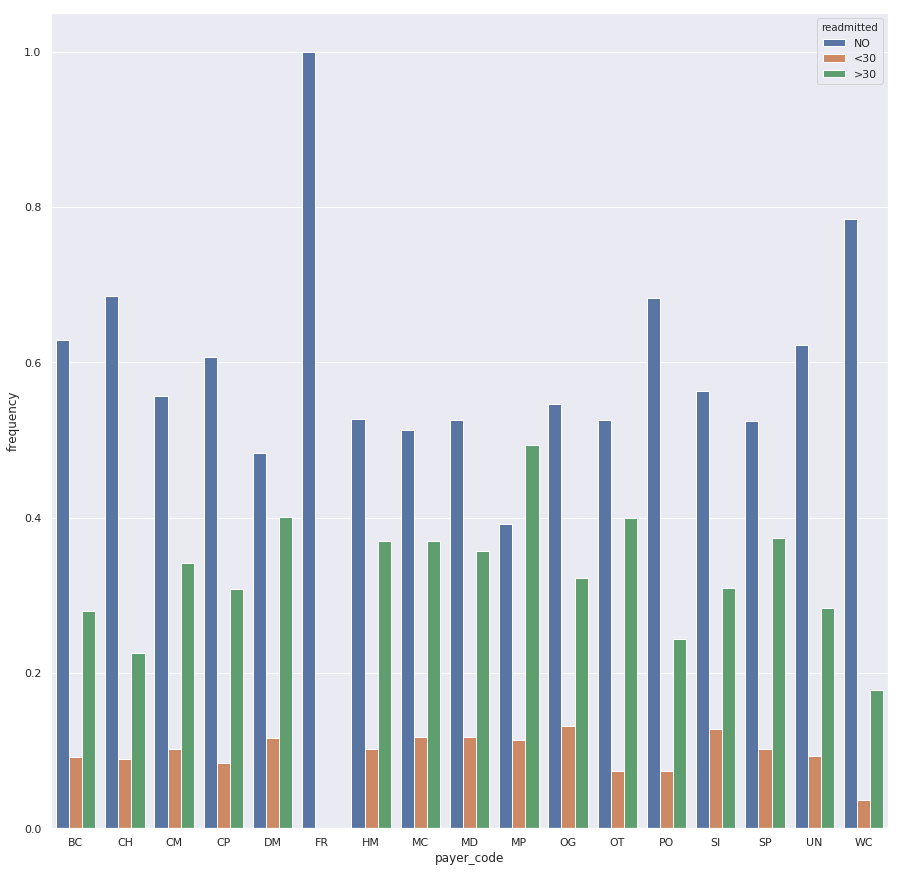

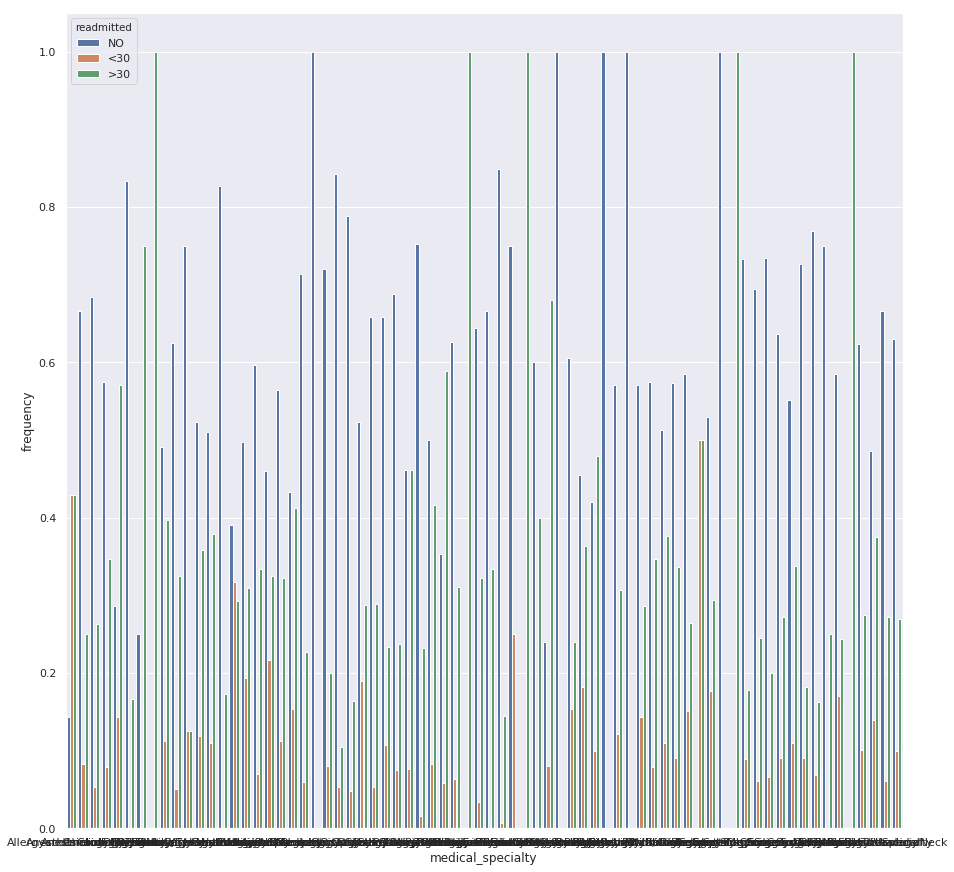

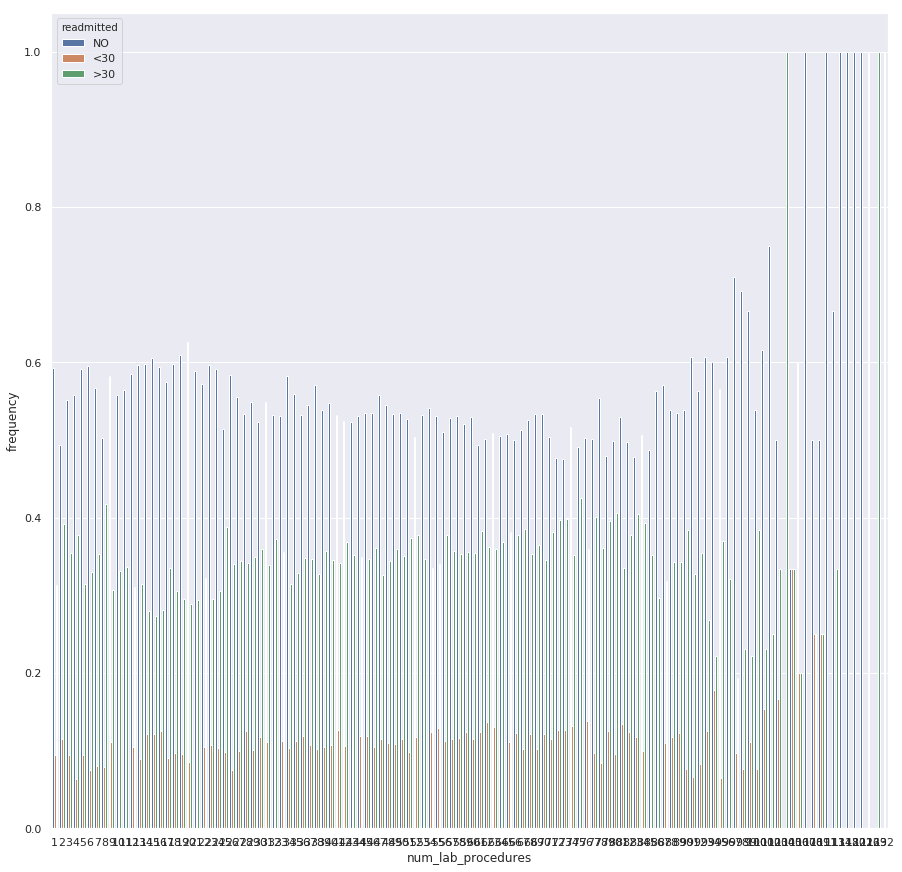

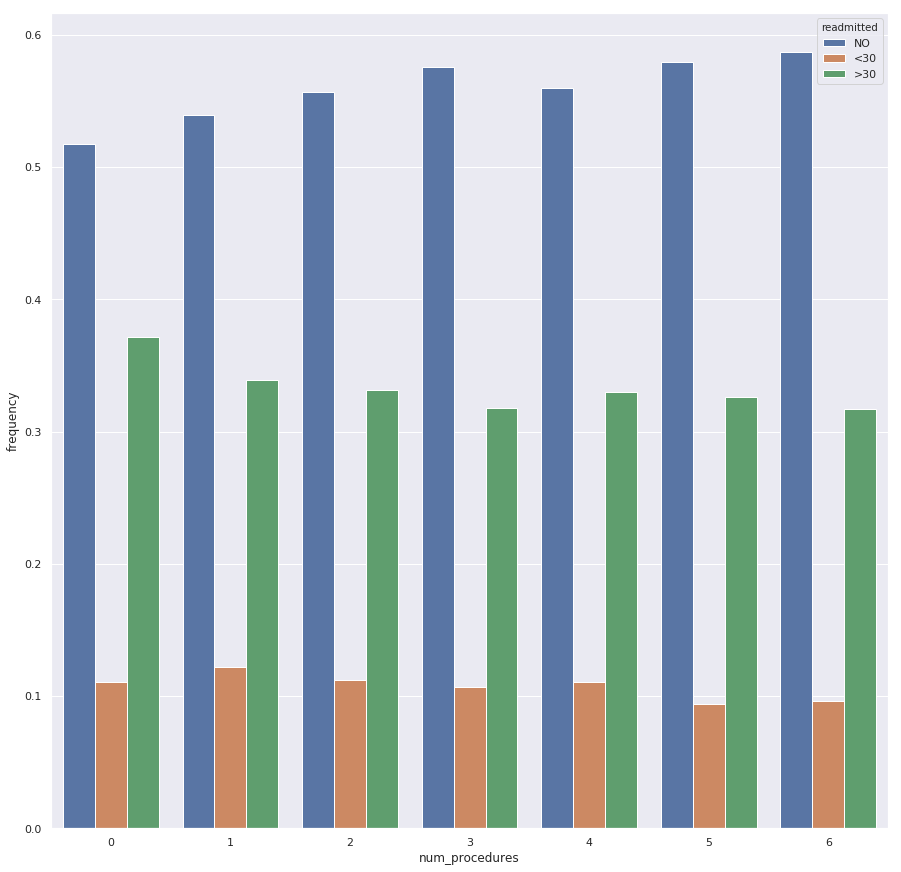

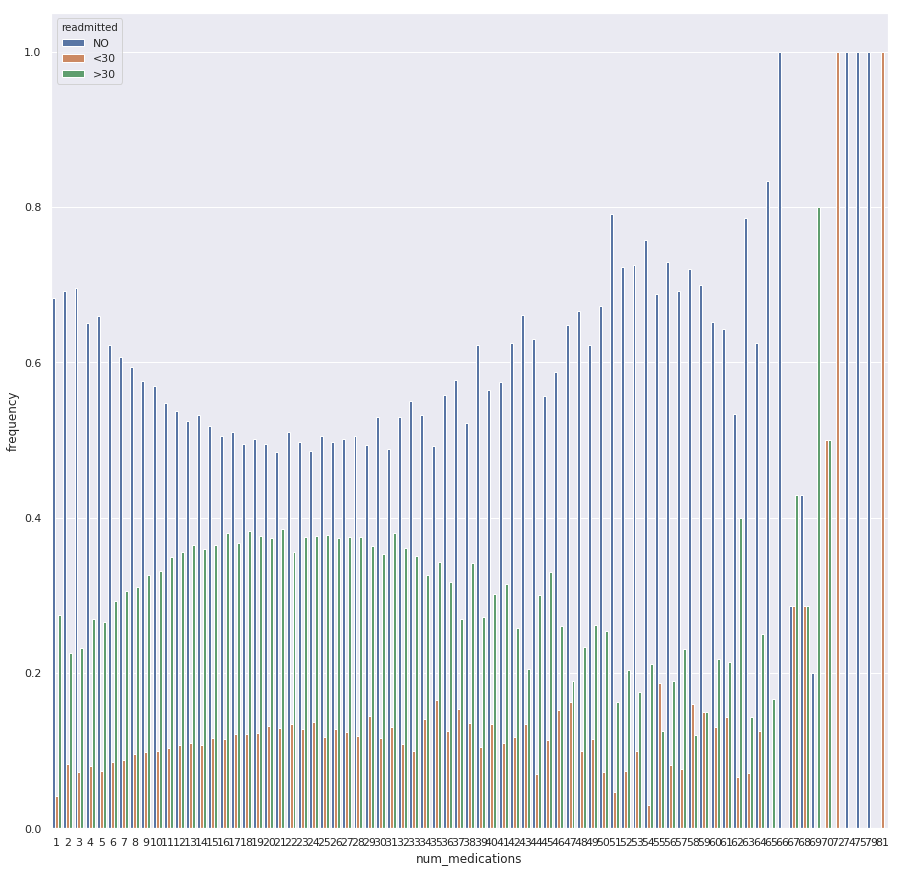

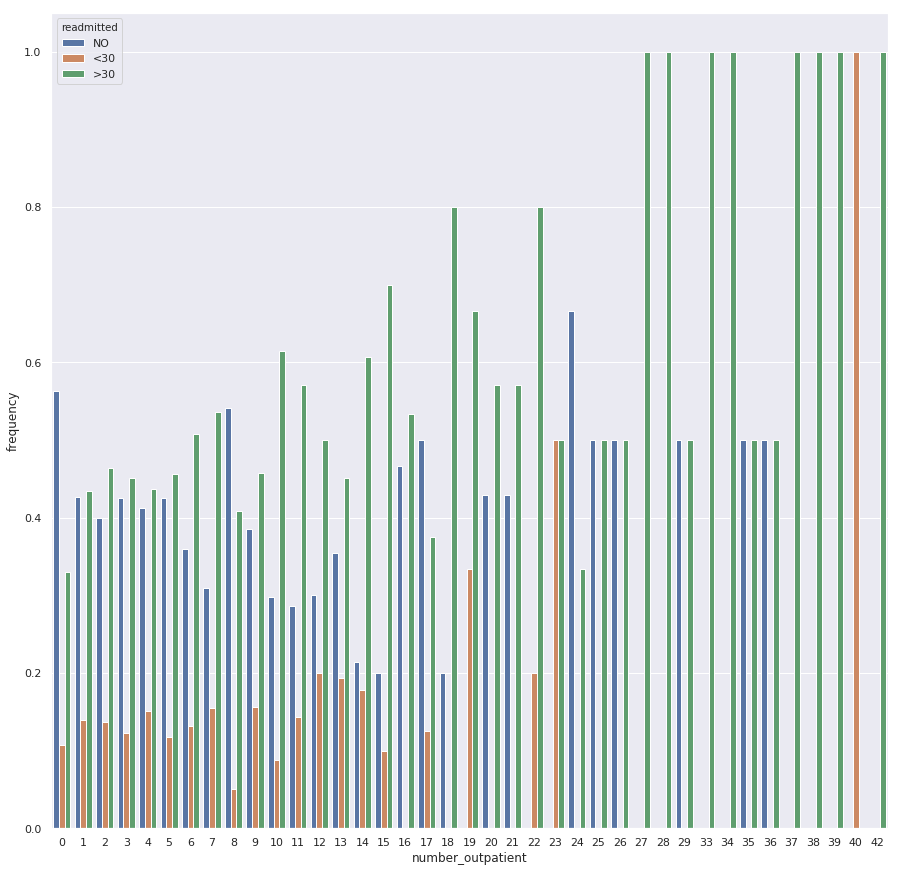

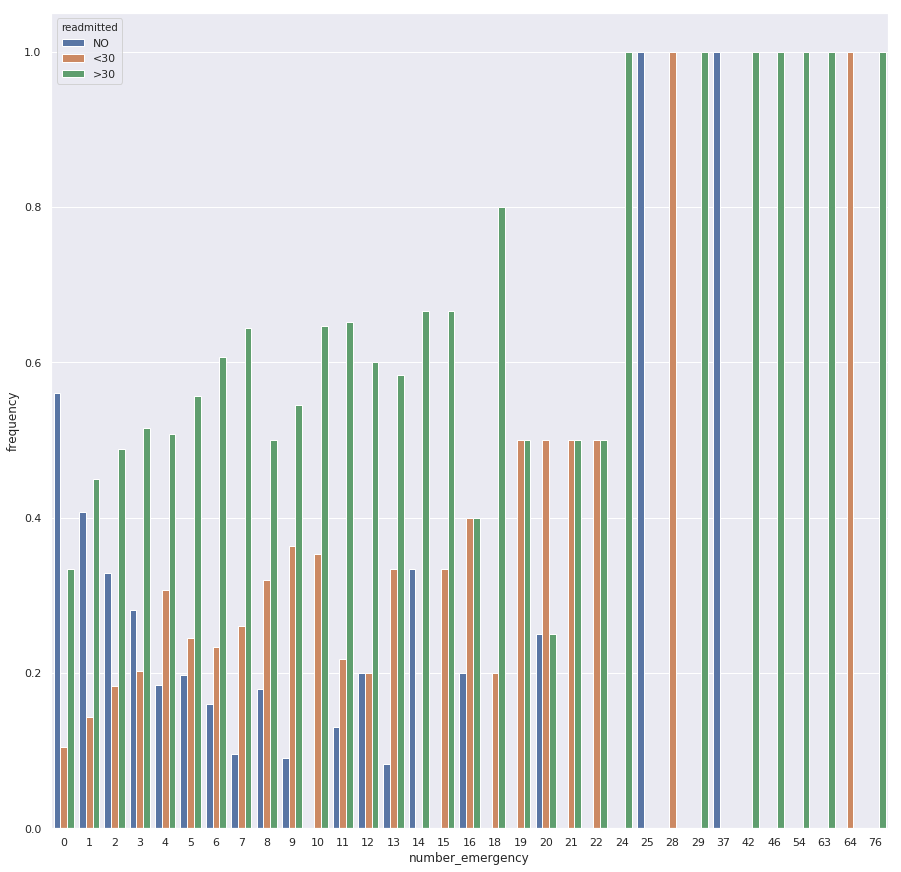

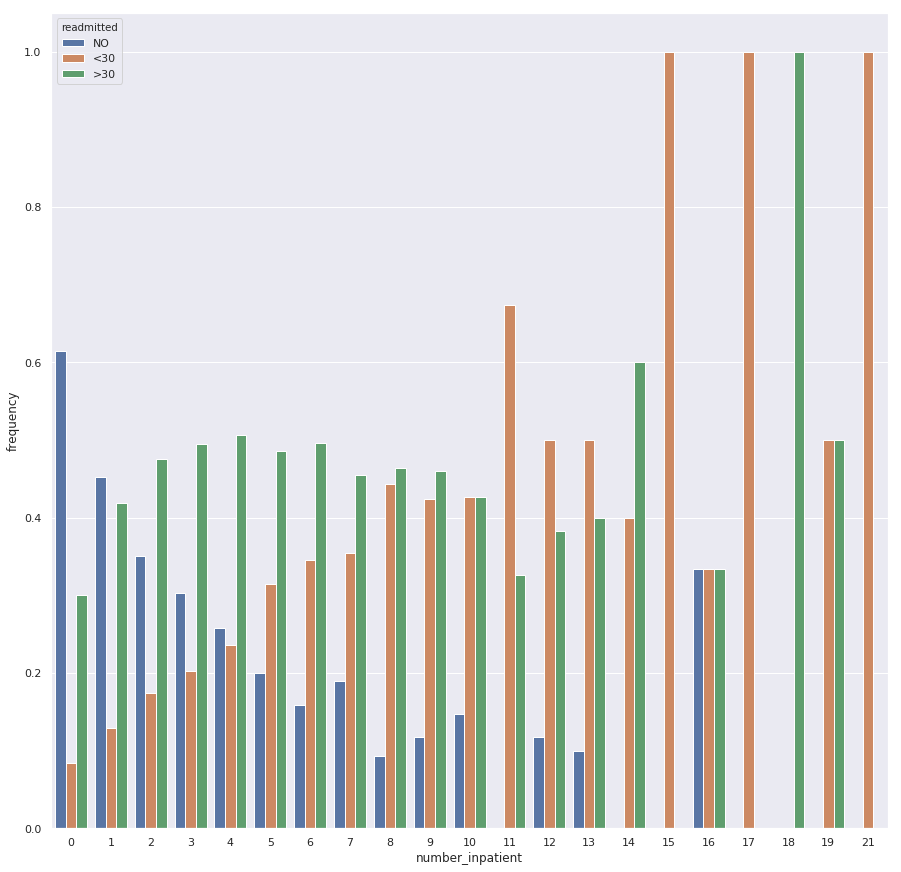

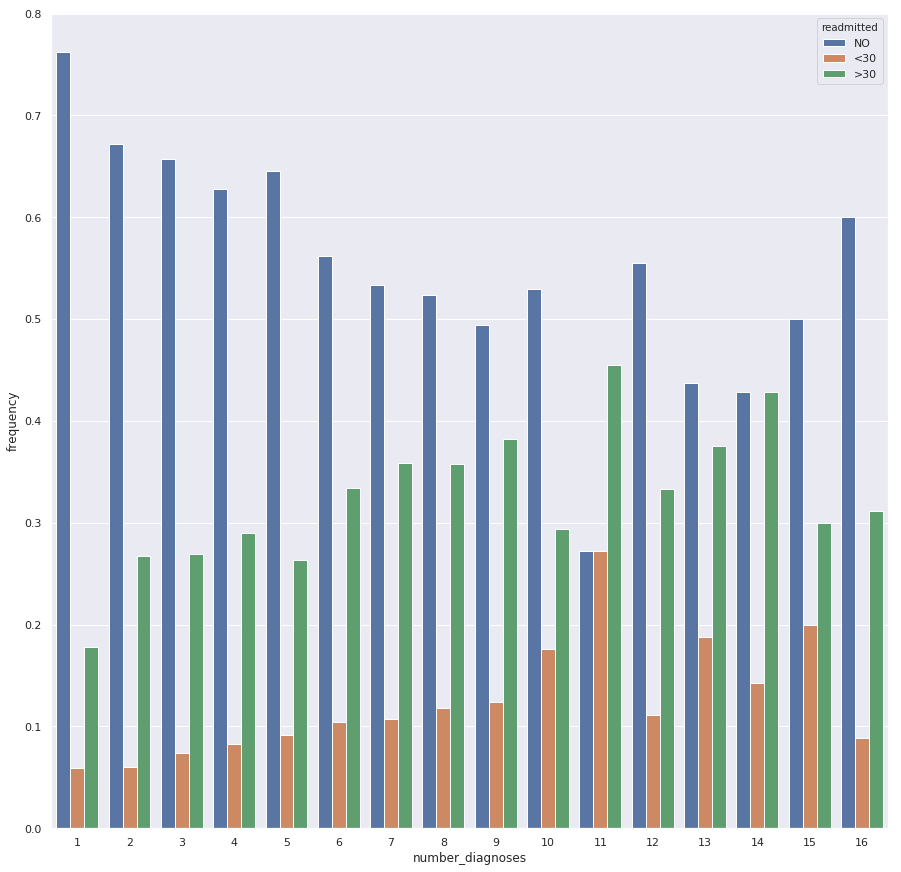

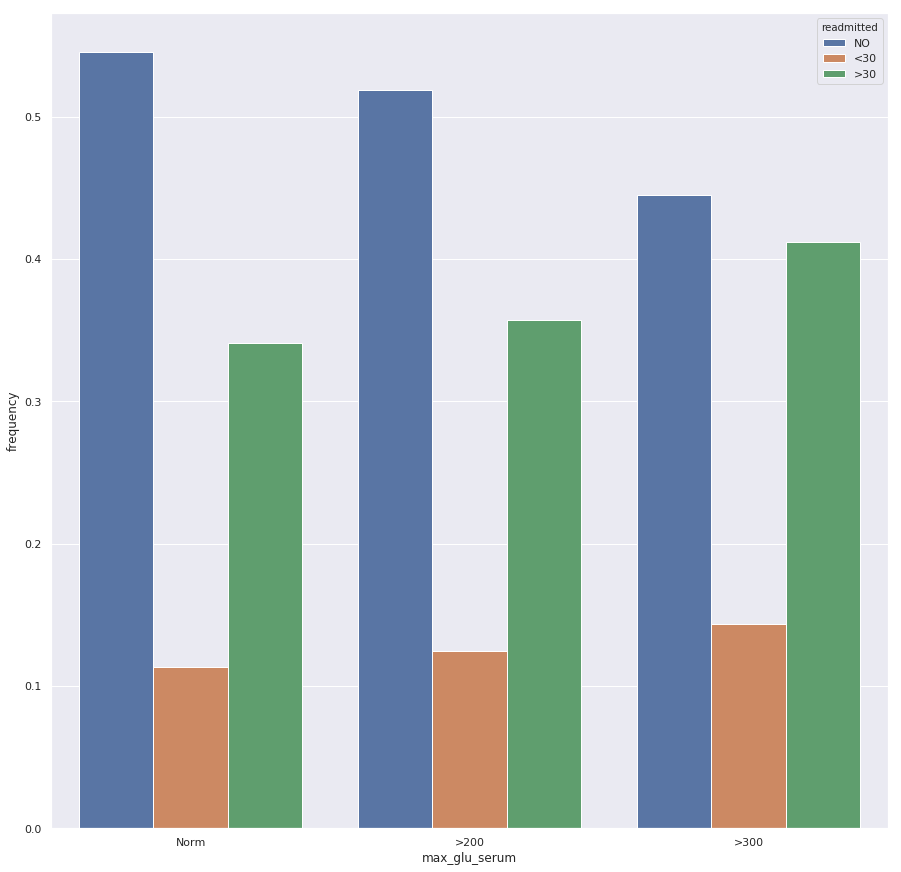

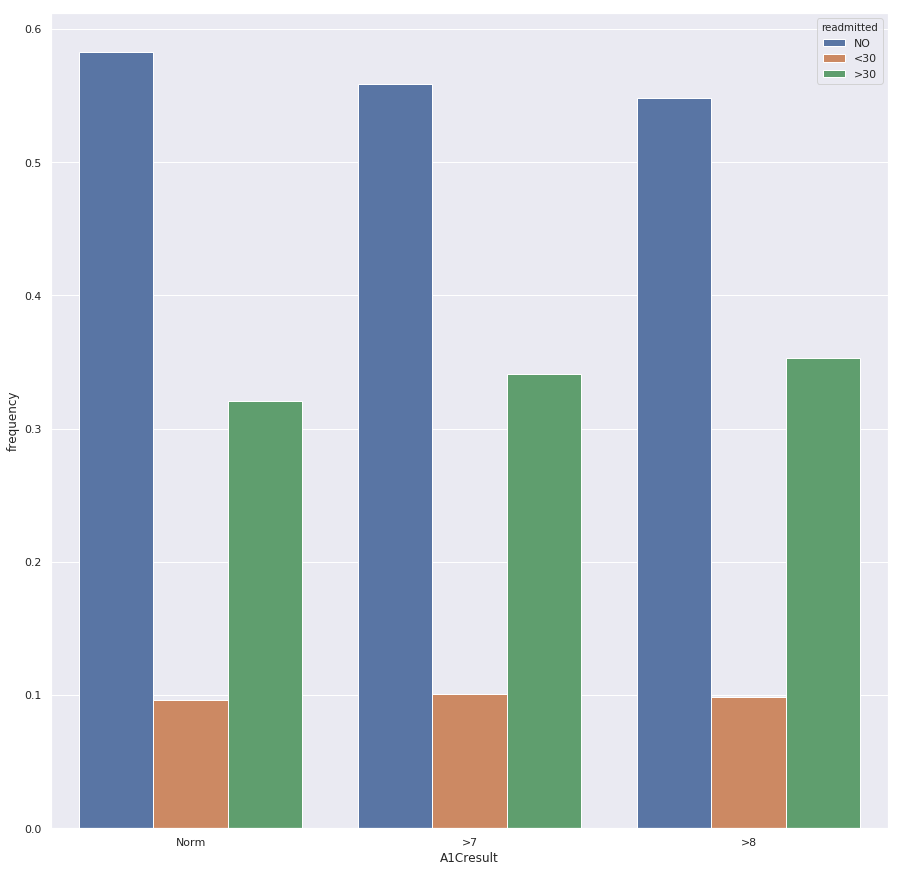

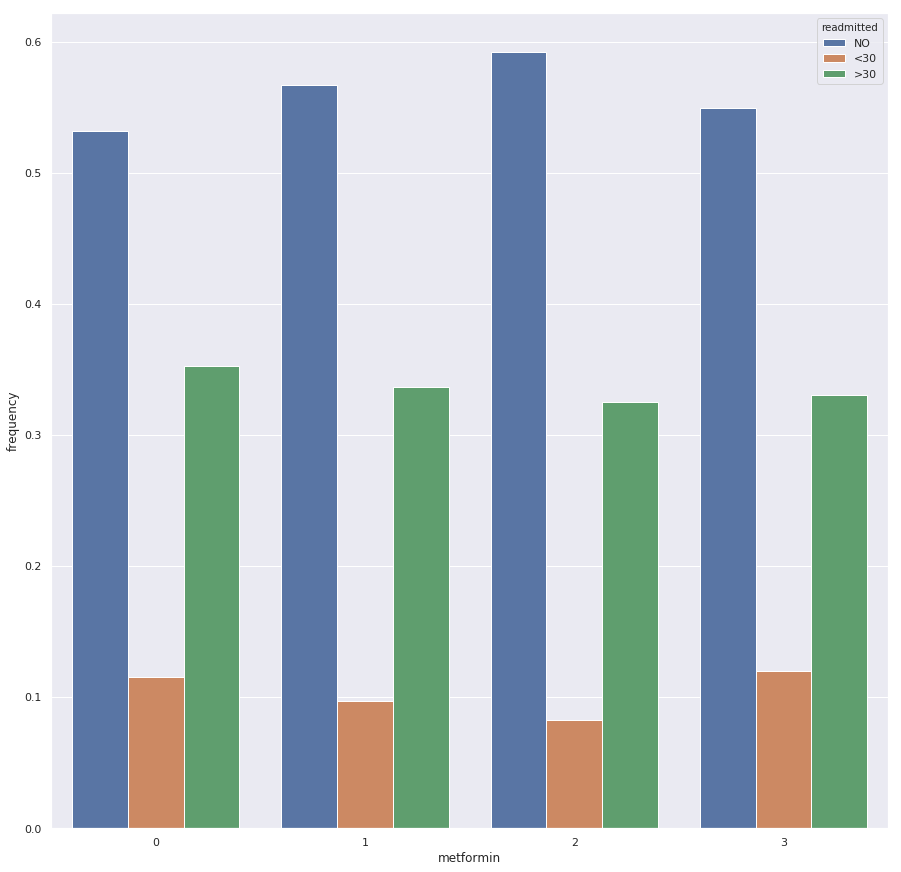

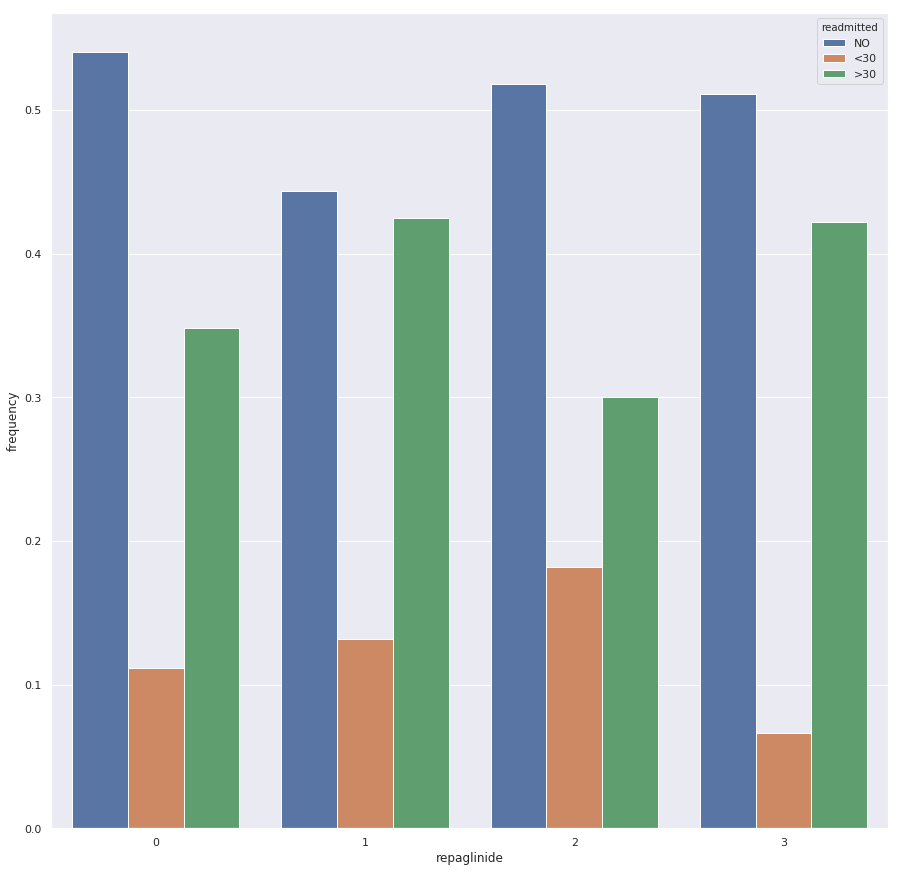

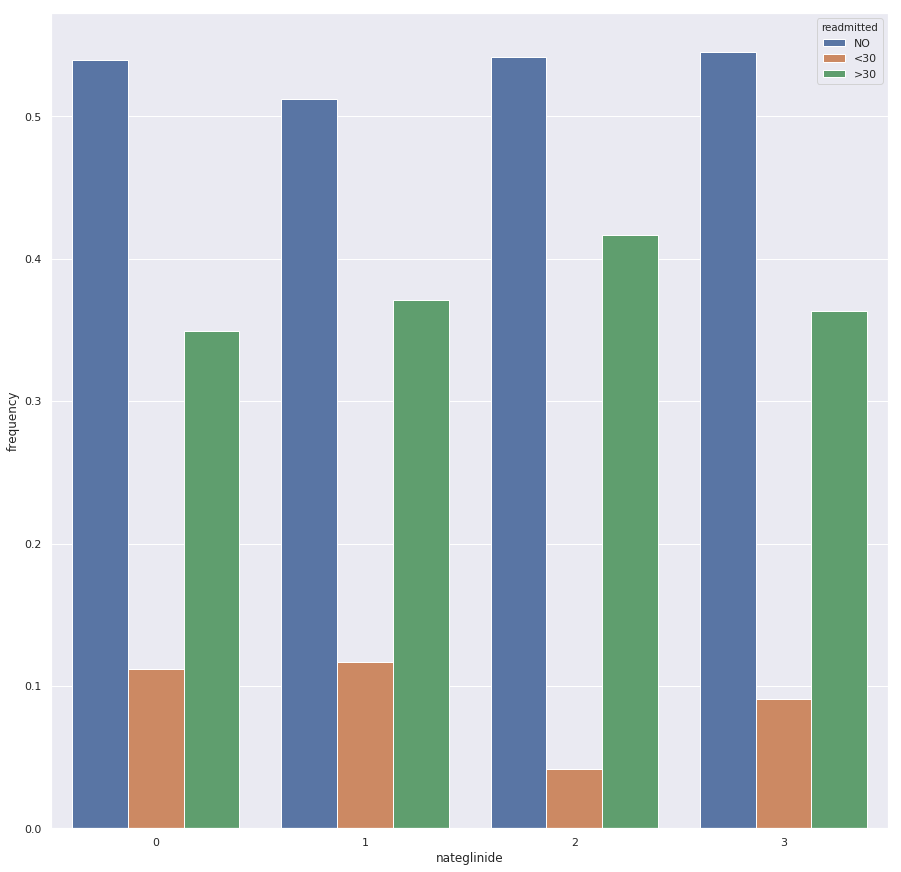

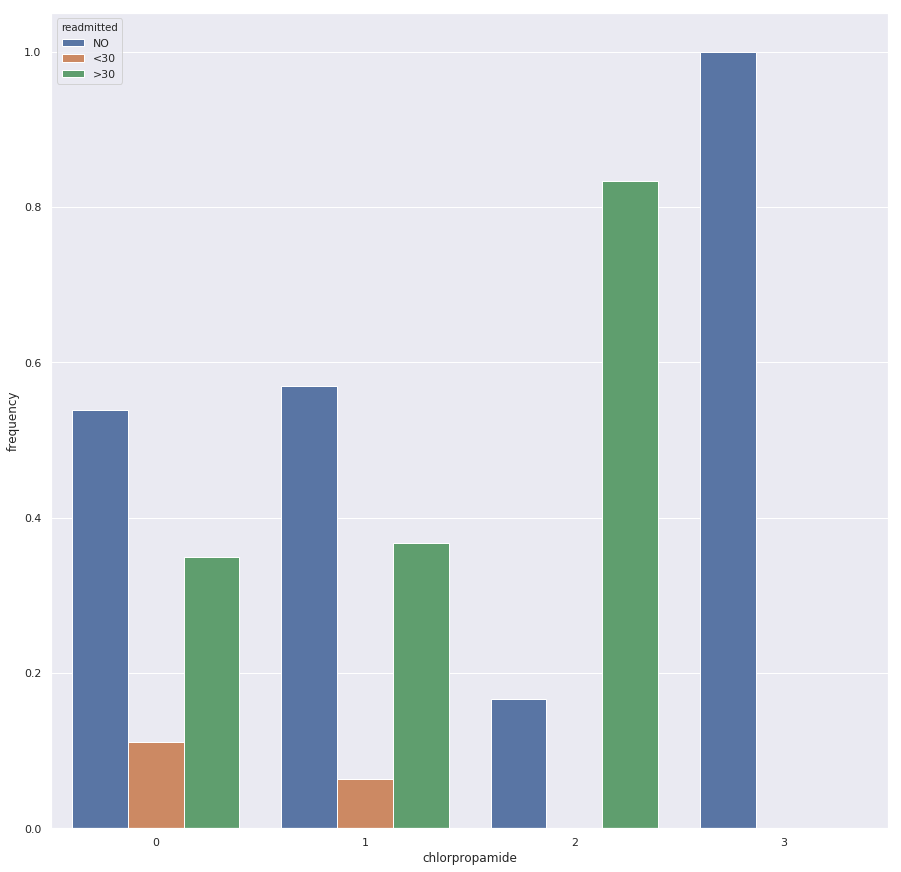

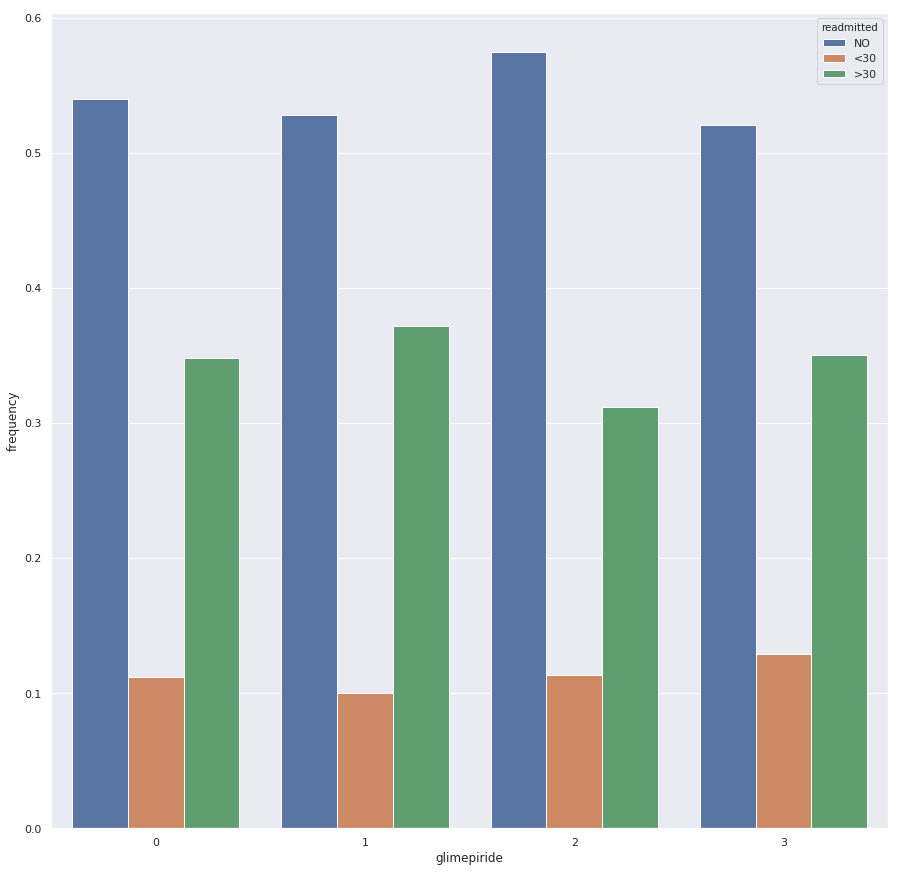

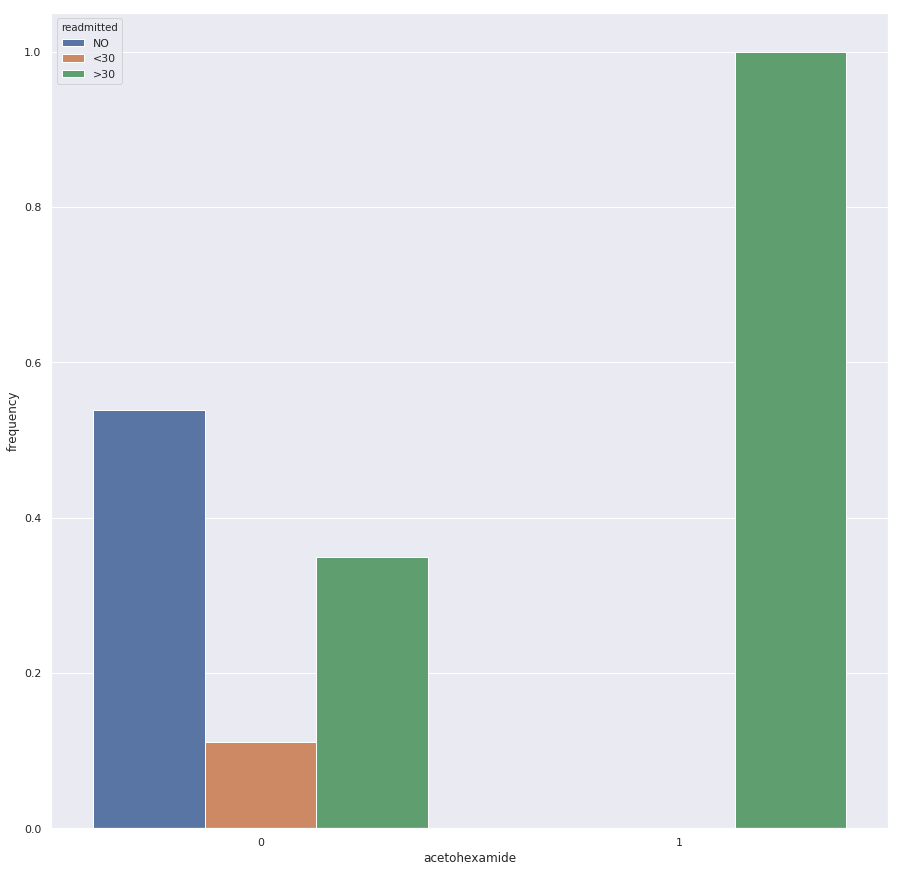

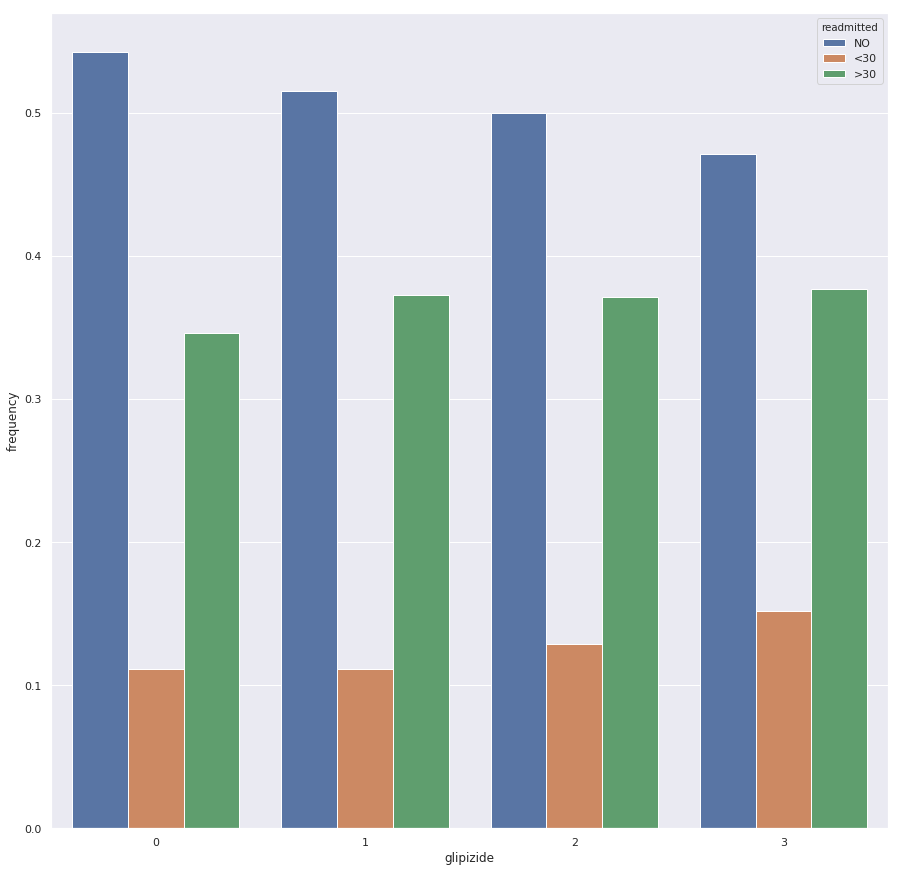

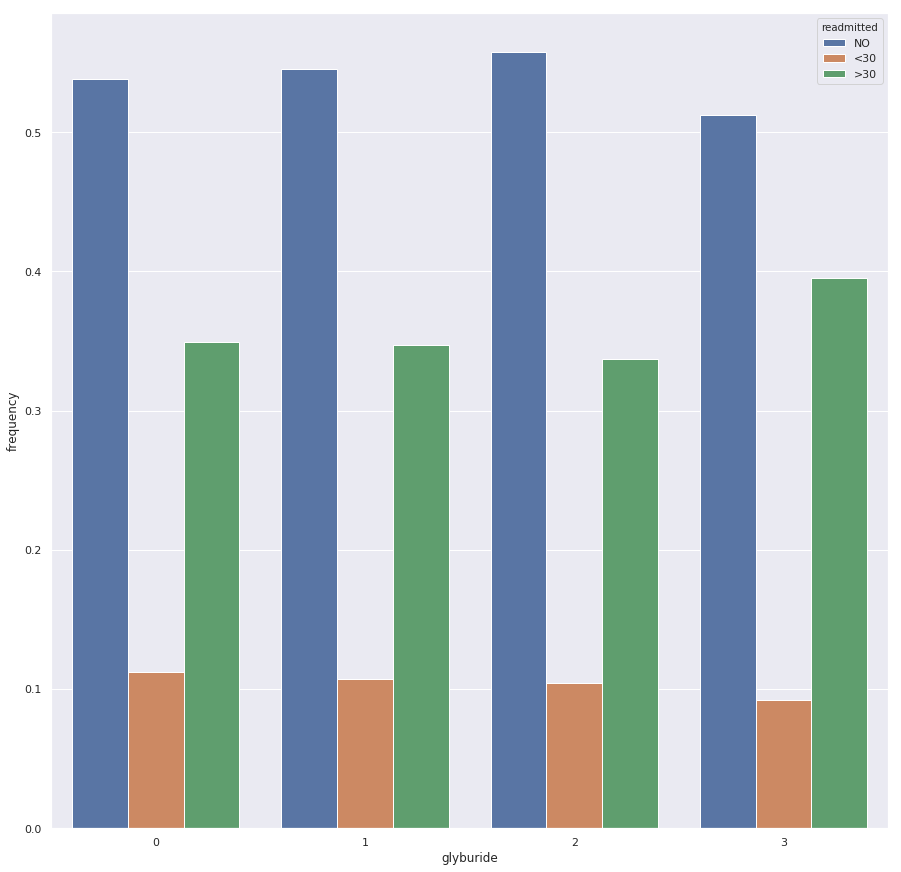

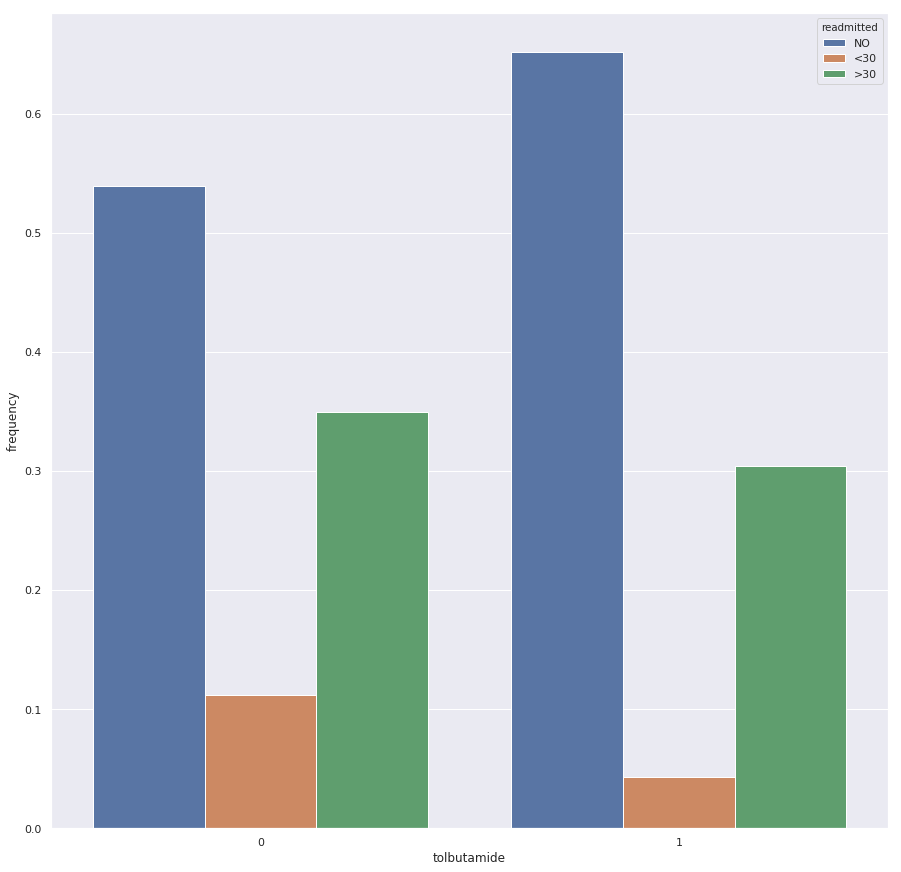

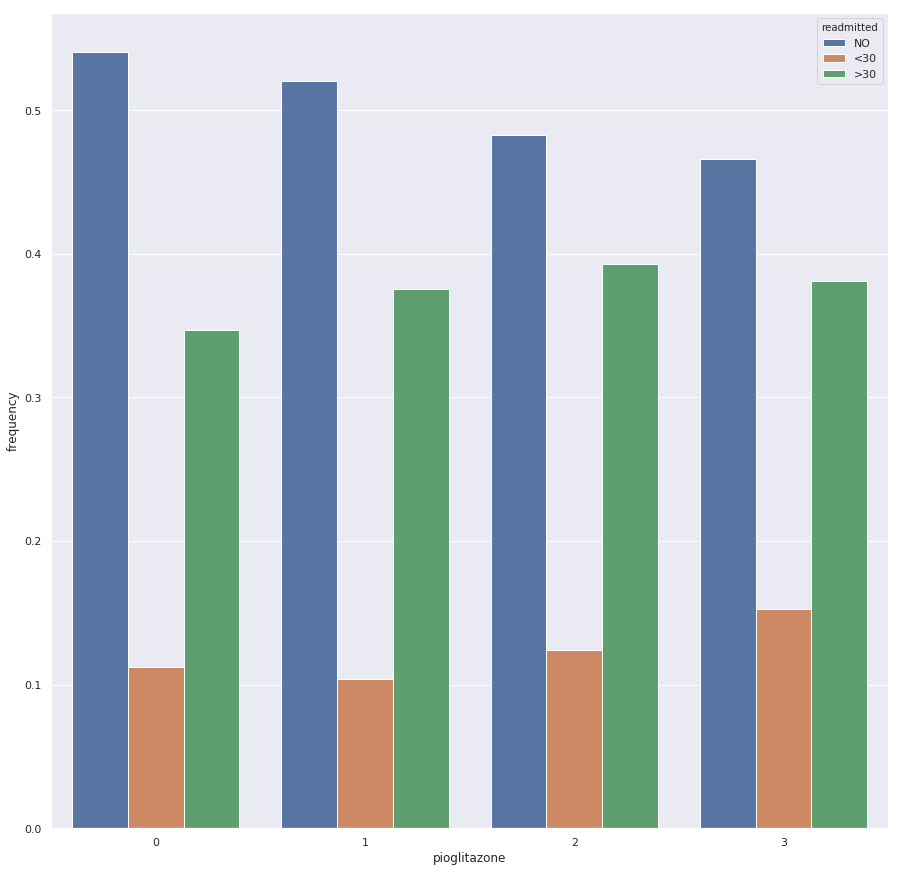

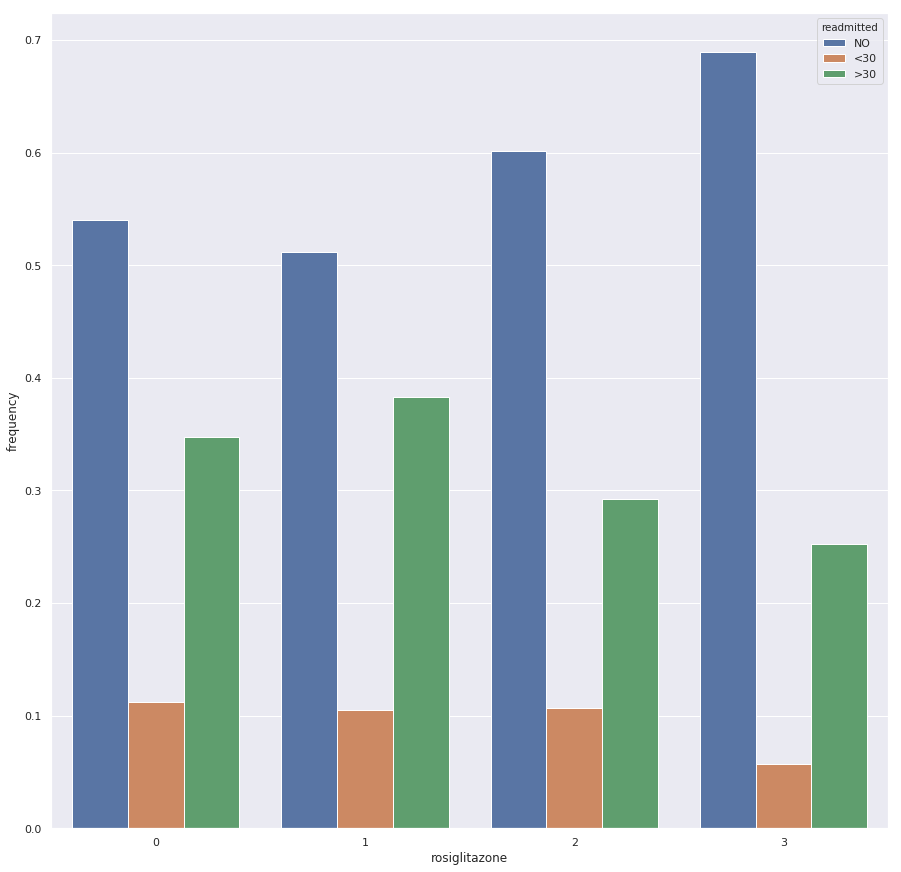

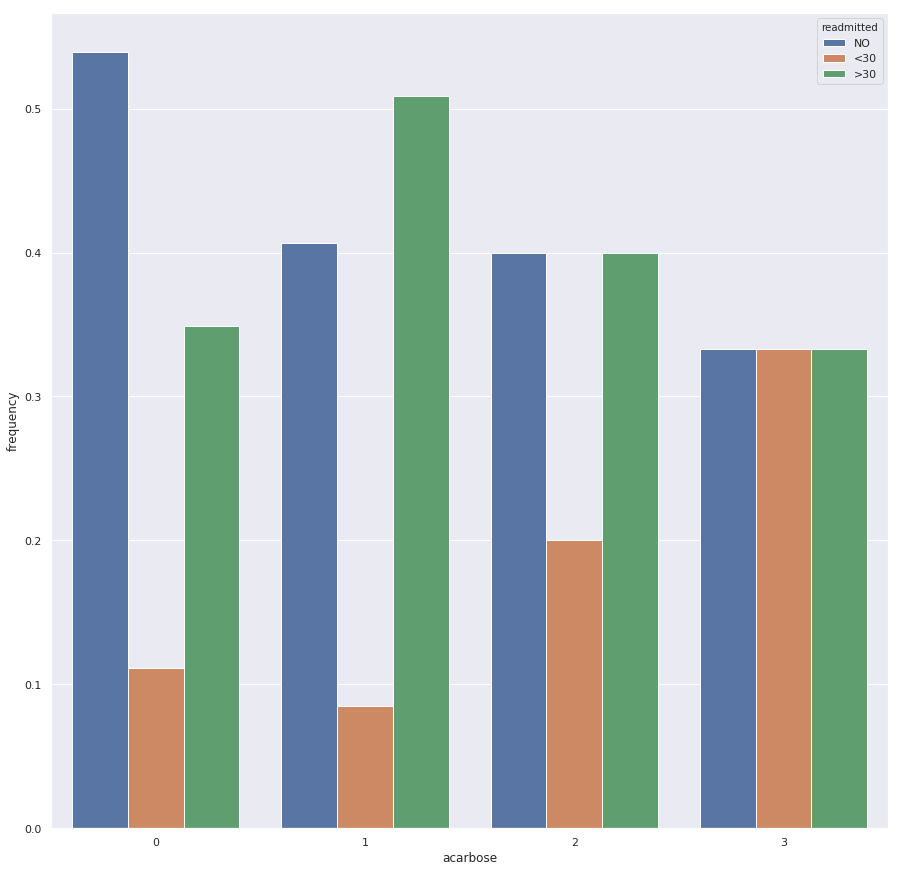

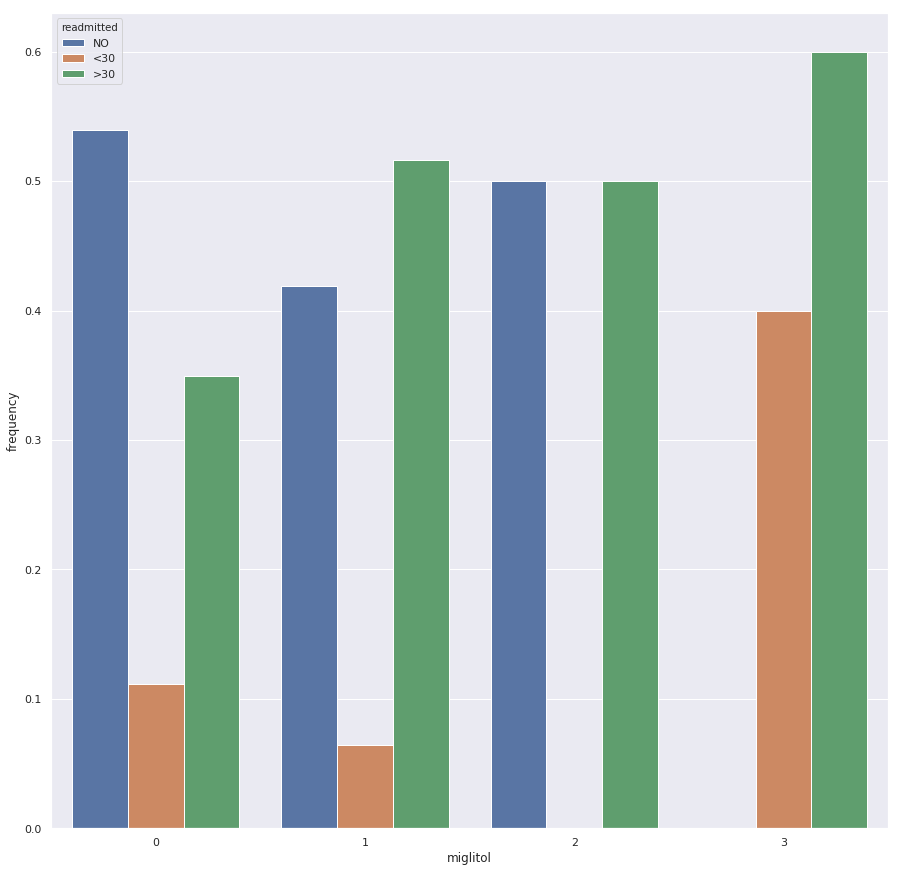

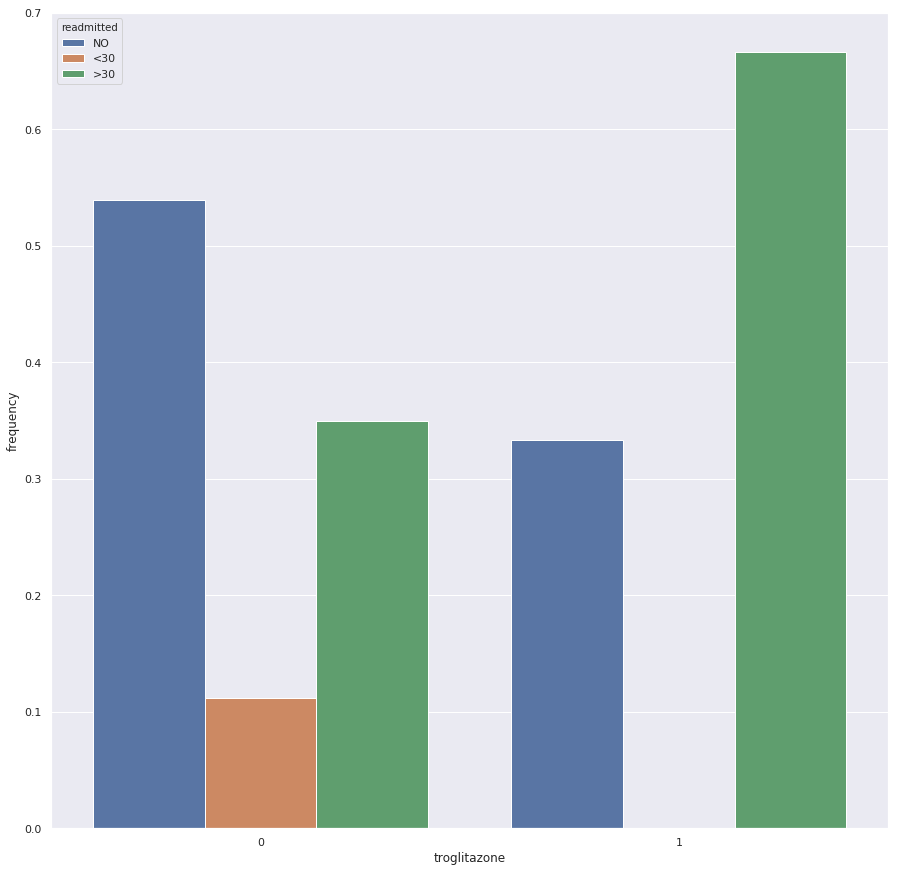

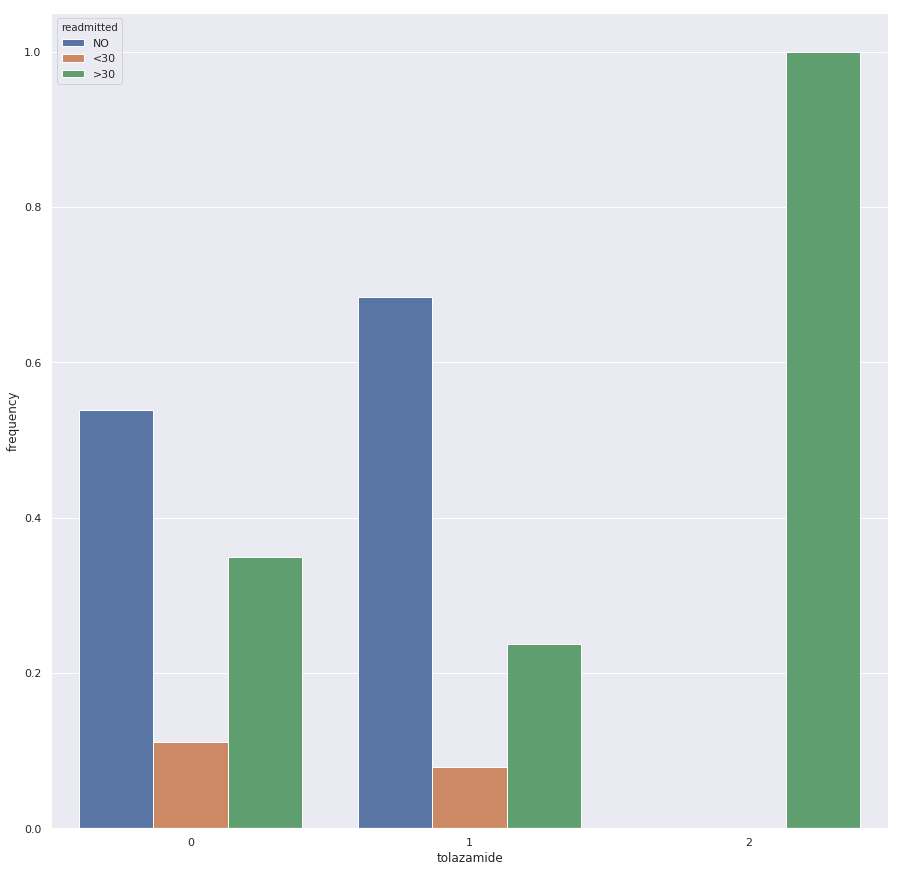

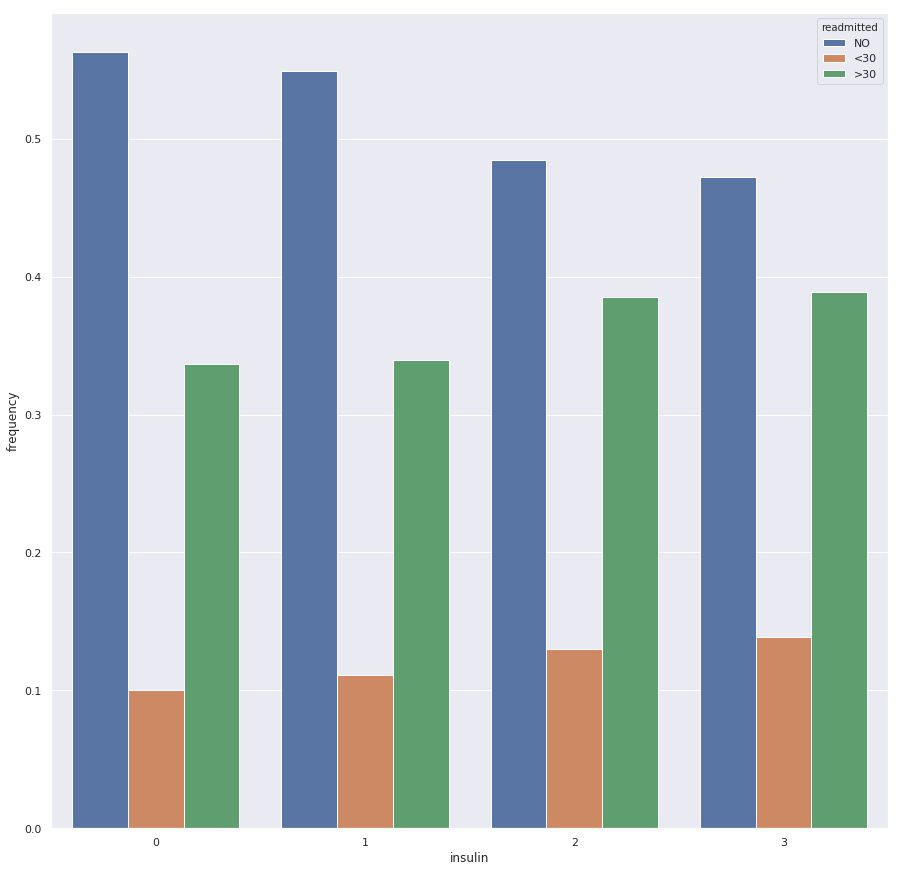

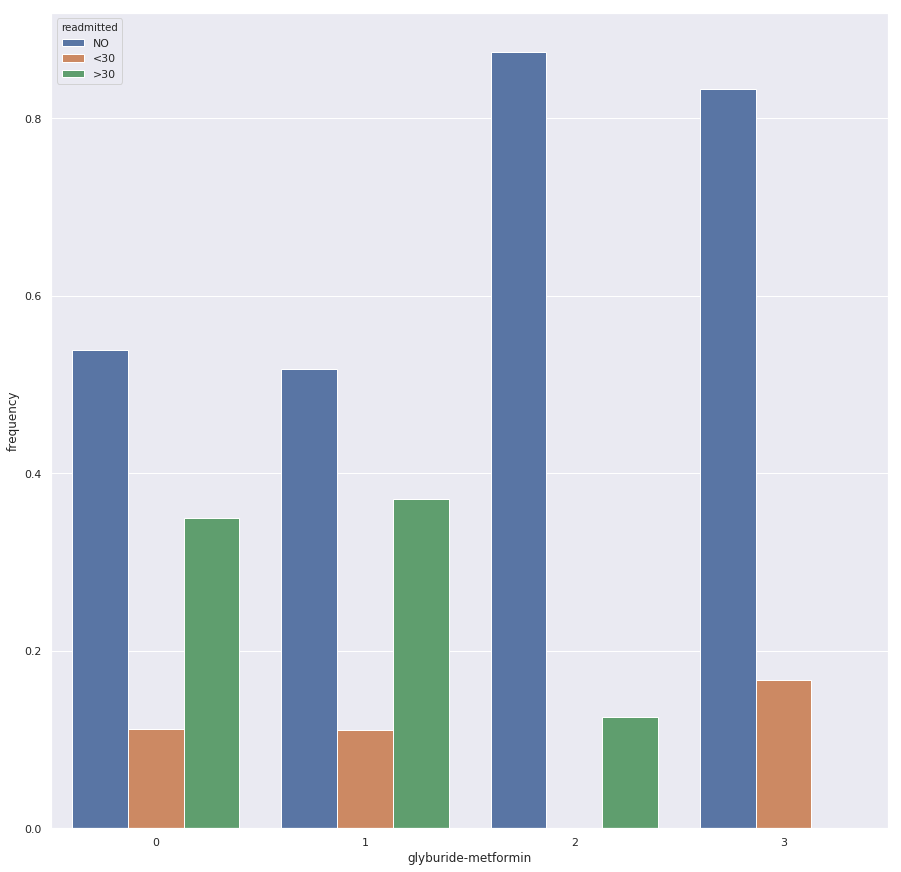

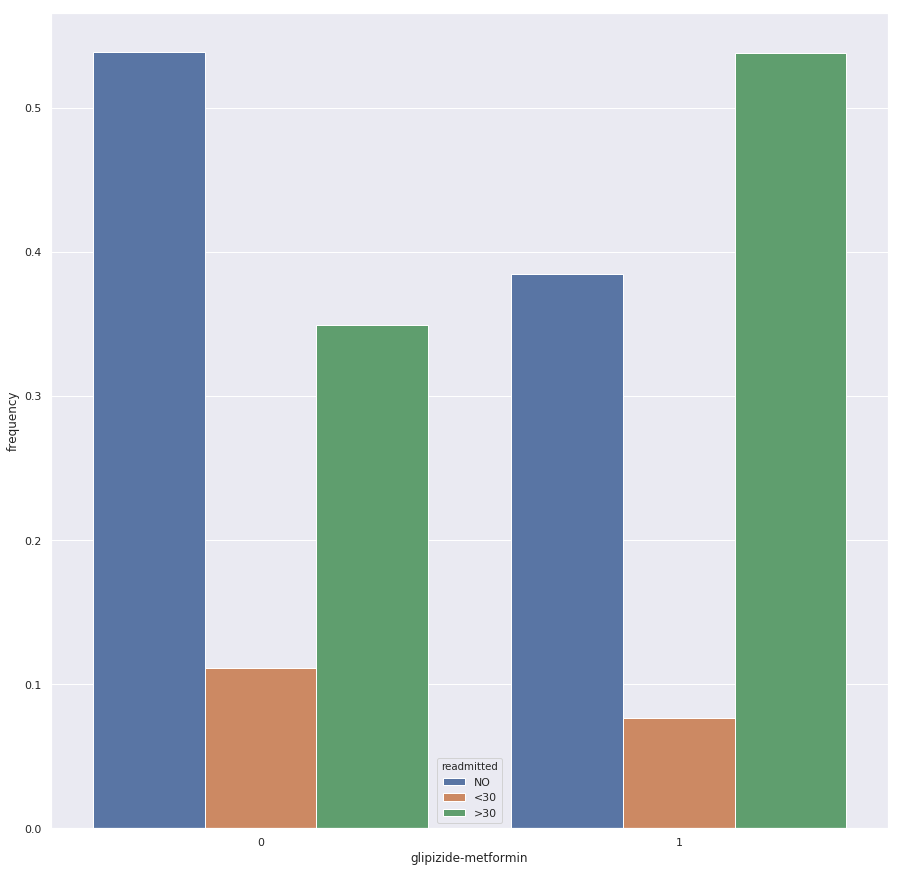

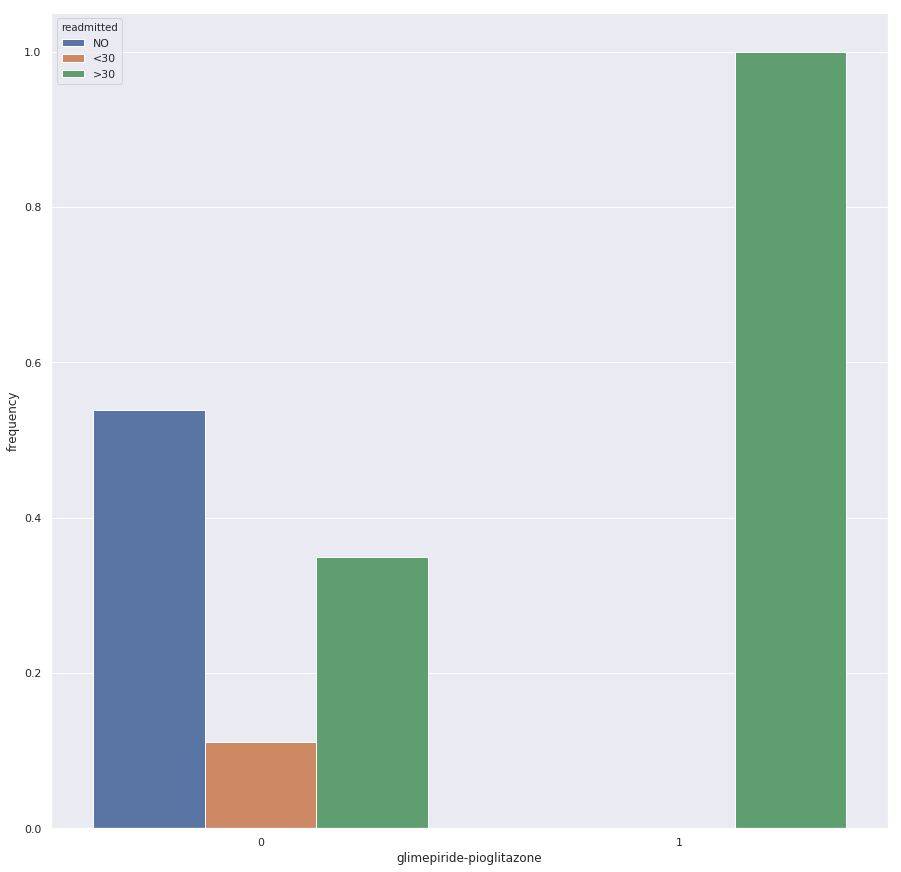

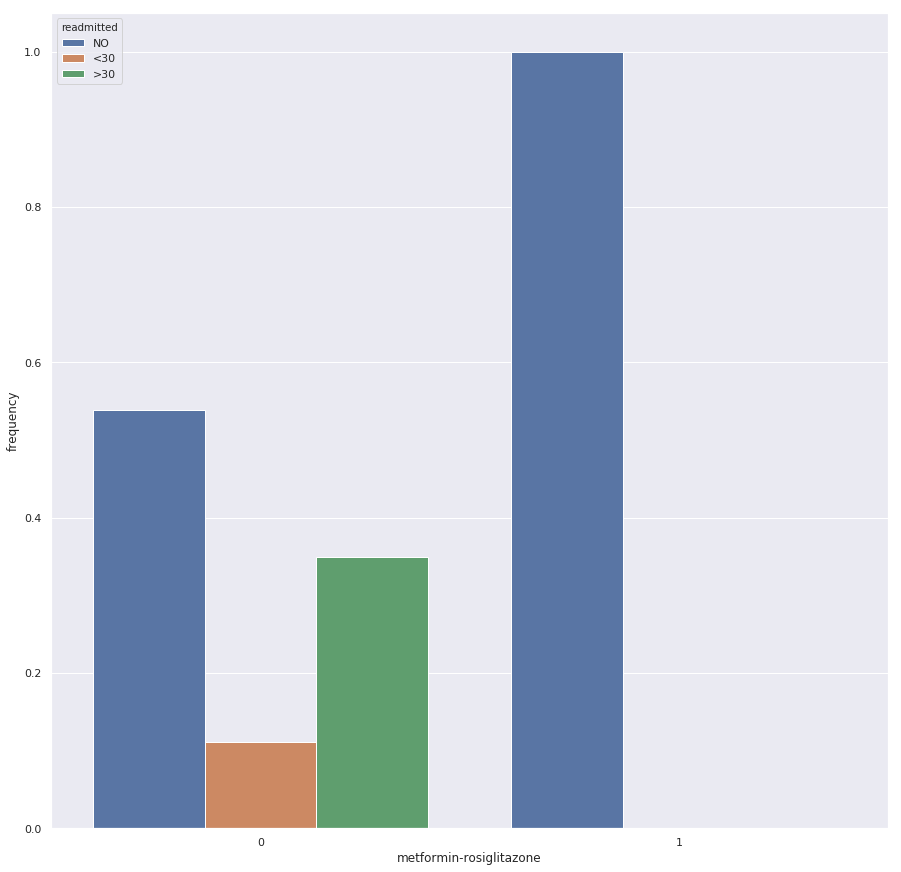

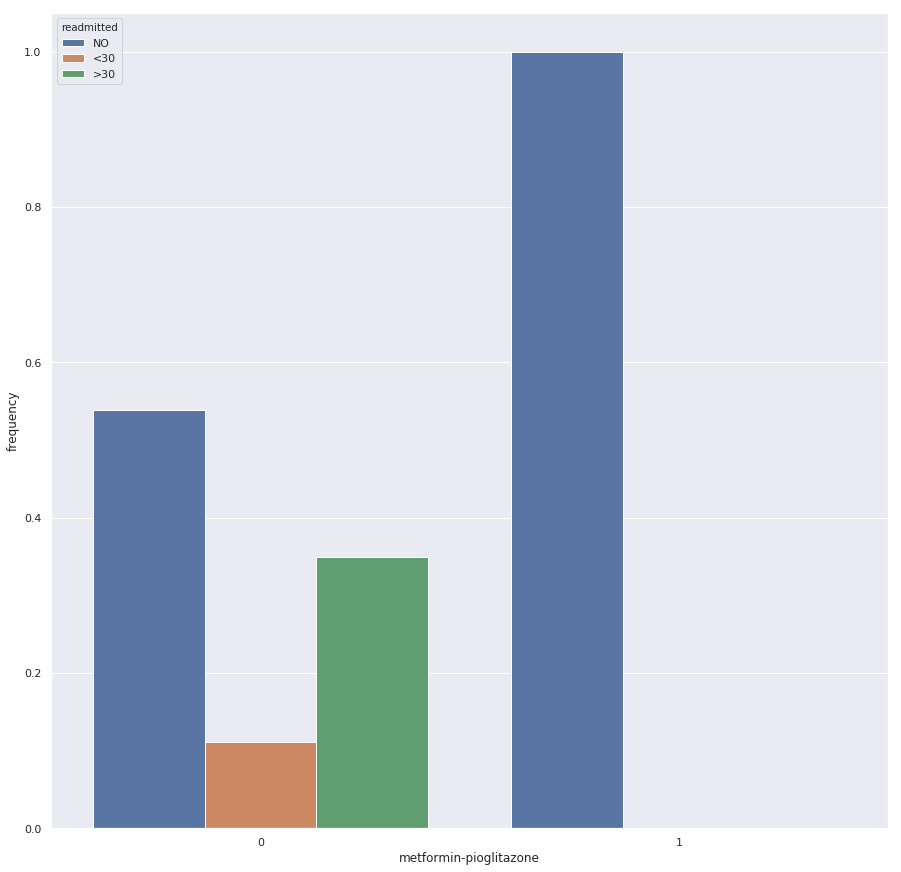

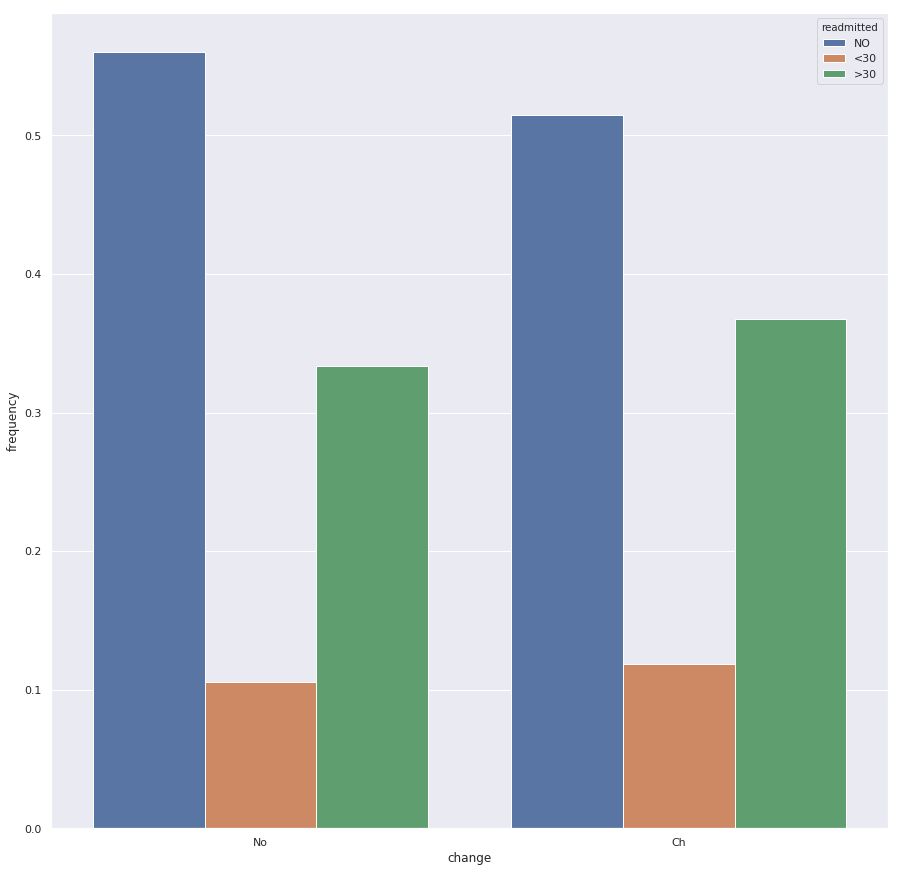

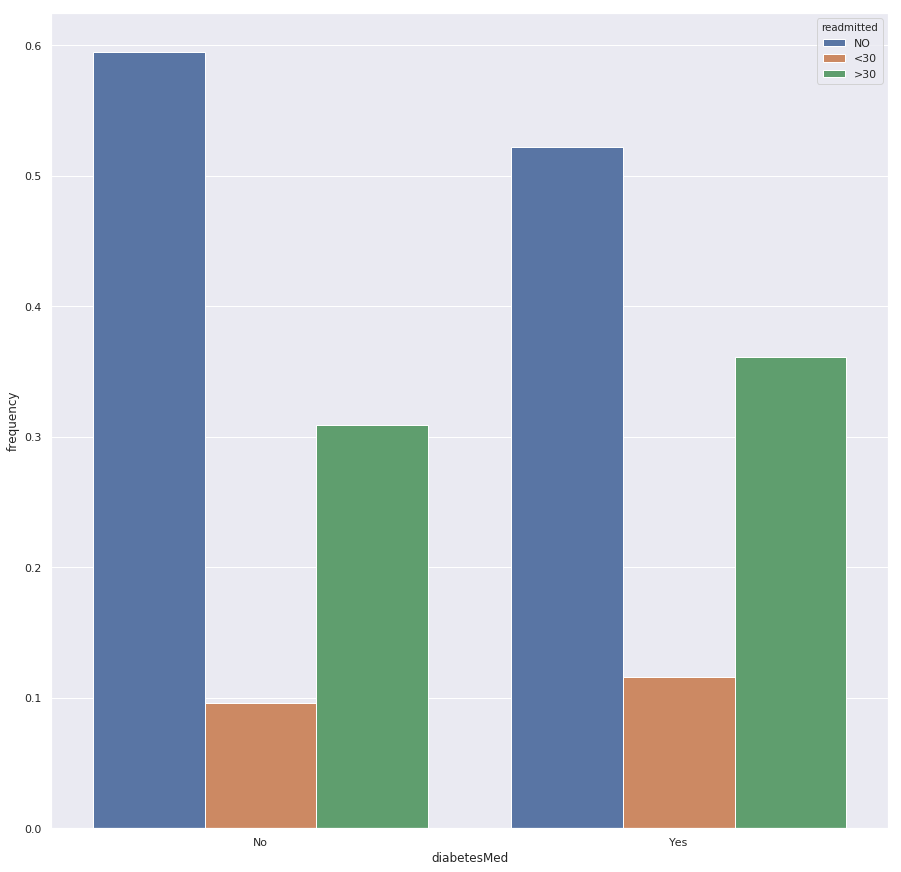

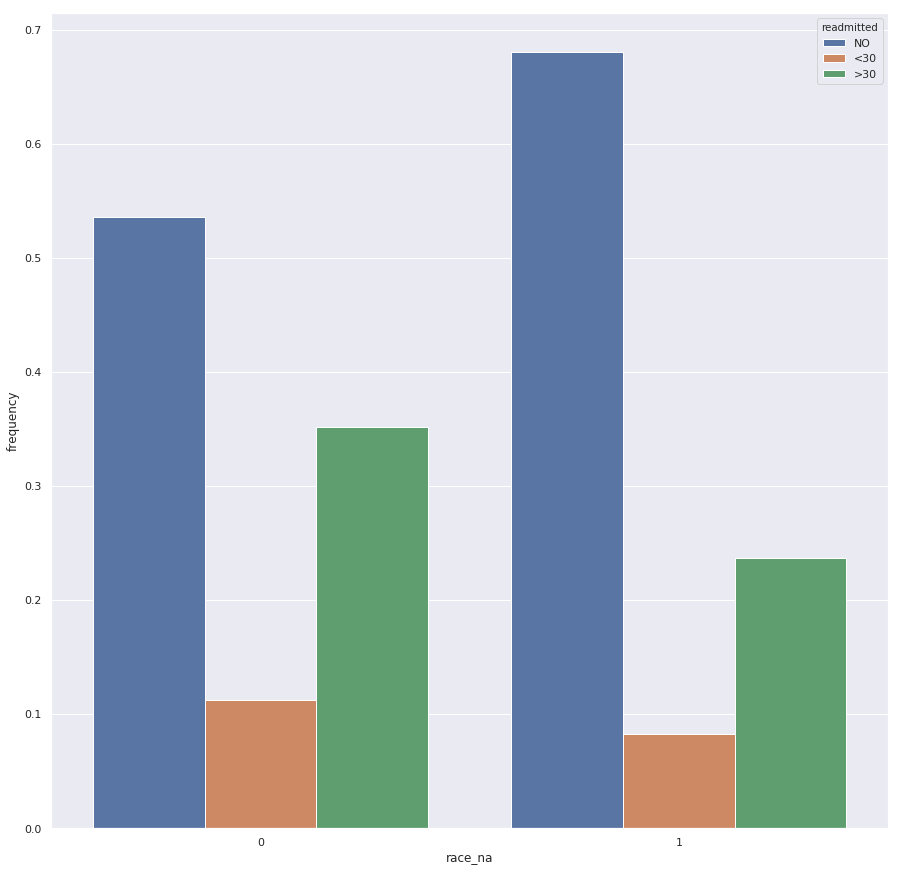

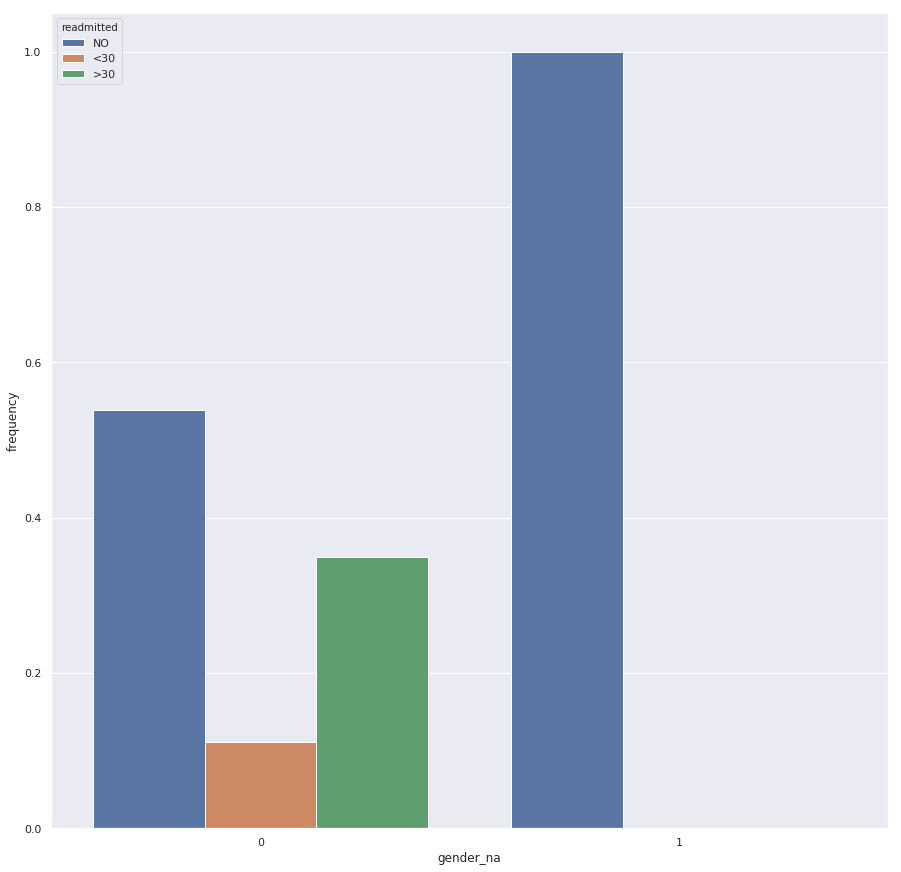

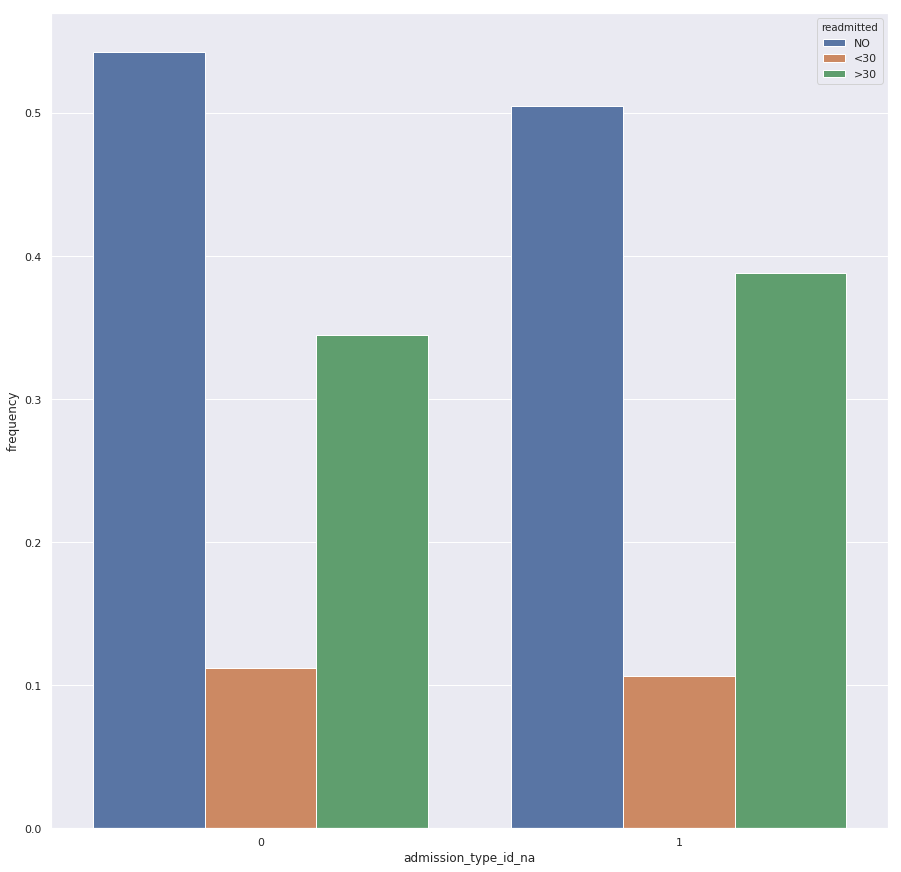

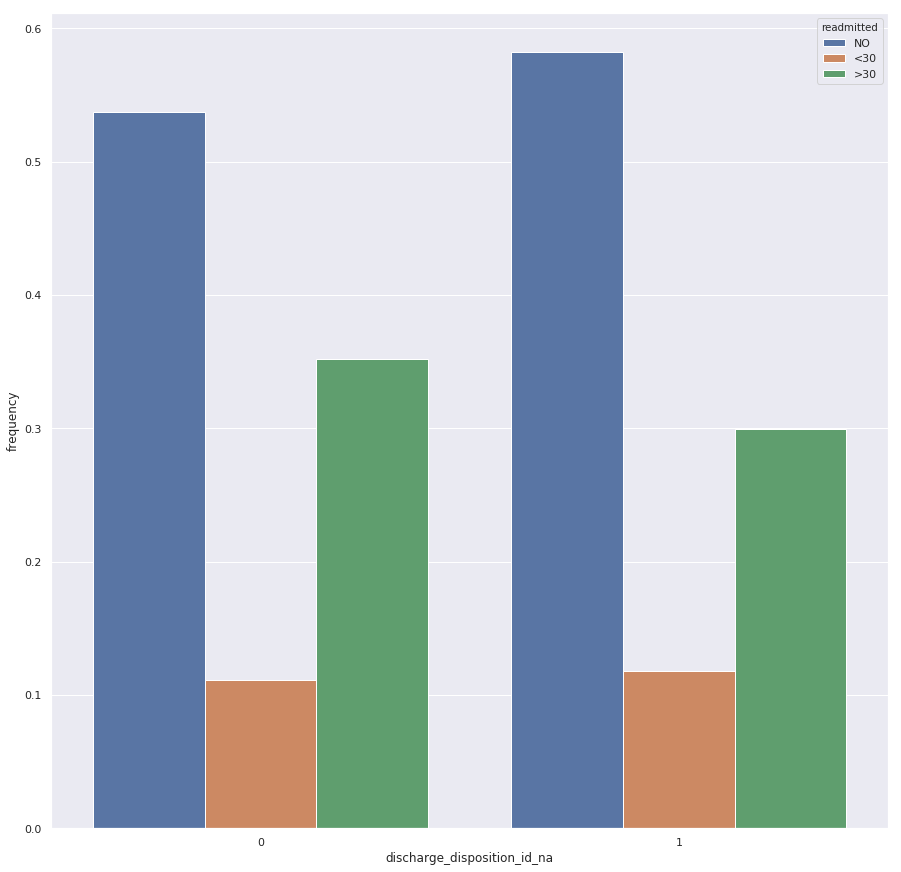

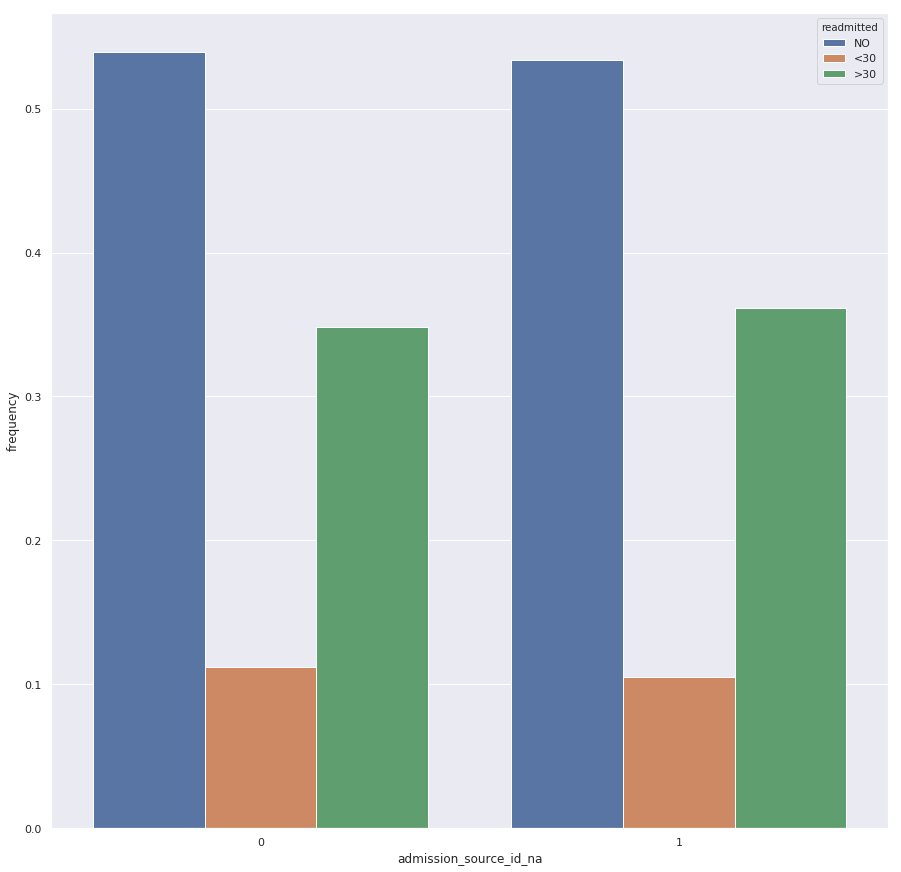

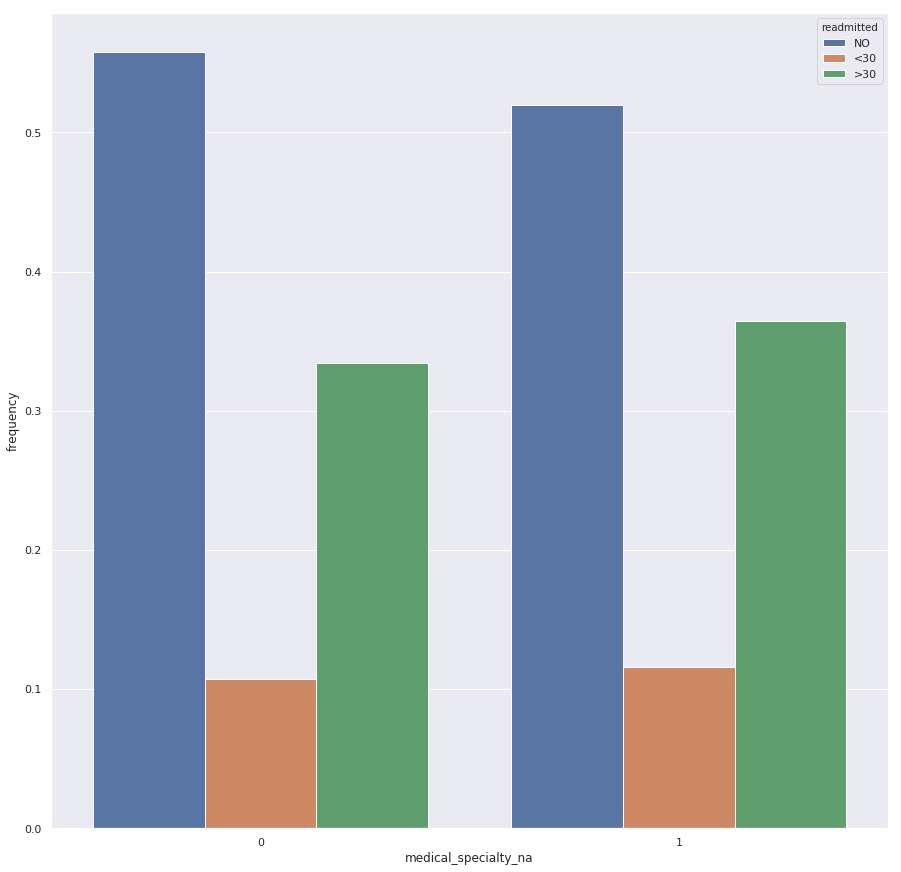

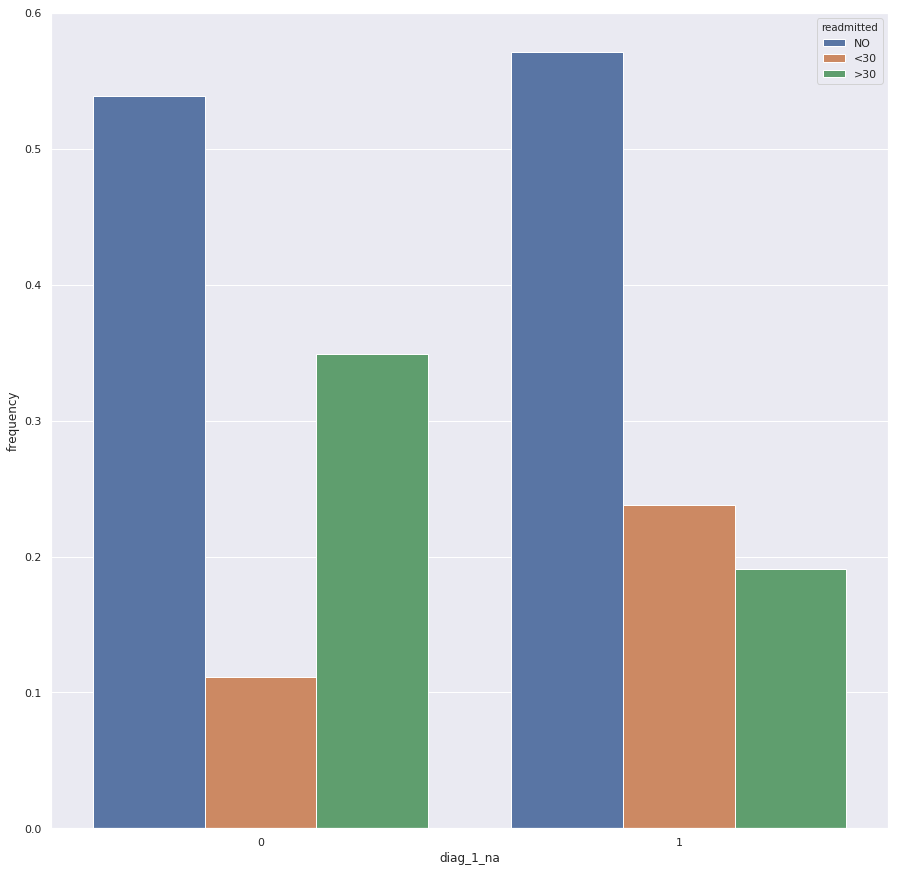

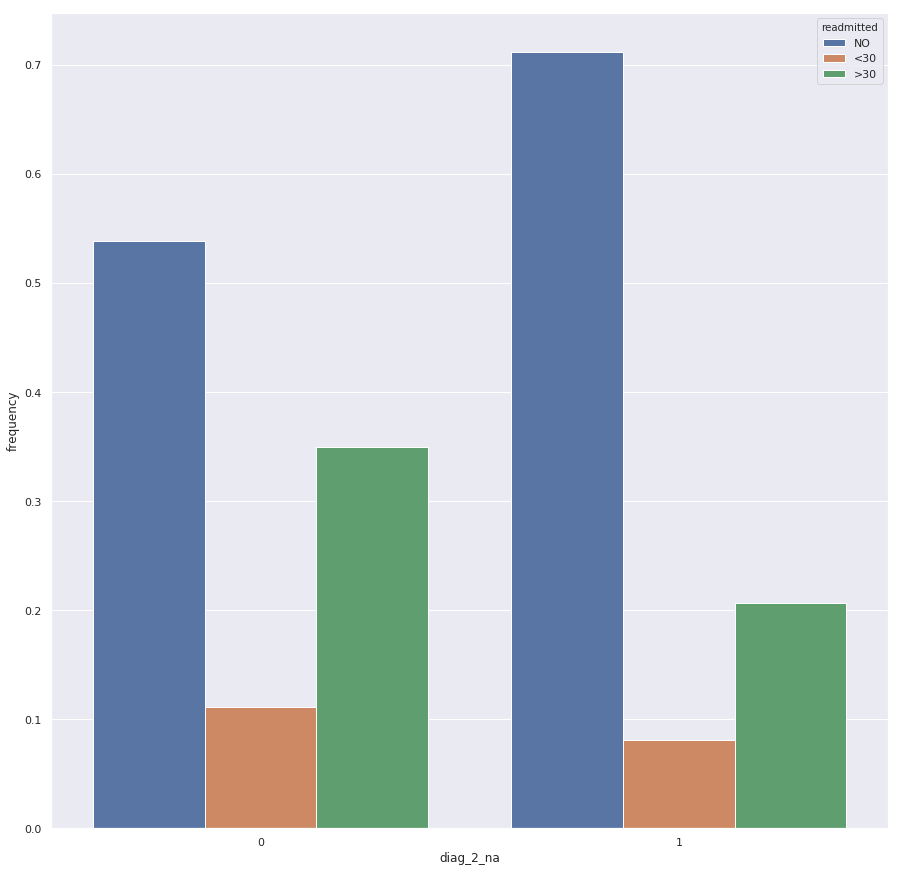

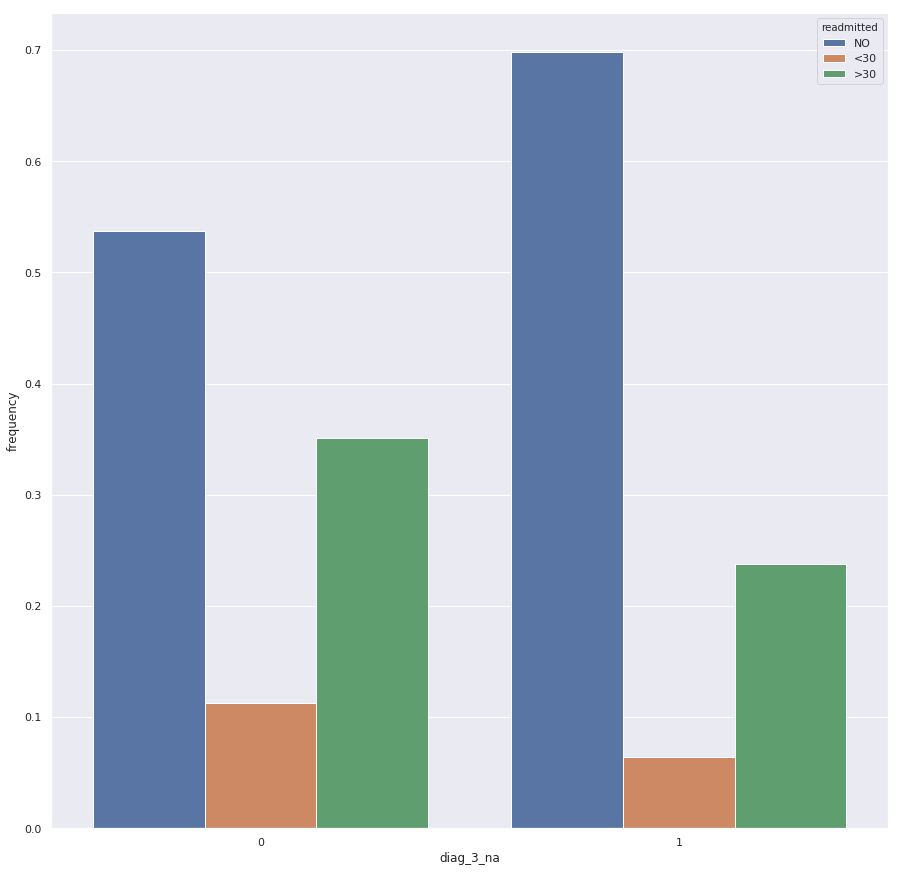

In [11]:
for x_column in x_columns:
    plt.figure(figsize=(15, 15))
    sns.barplot(x = x_column, y='frequency', hue='readmitted', 
                data=frequencies_by_groups(df, [x_column, 'readmitted'], df_labels))
    plt.show()

It is clear that some variables show differential distribution of `readmitted` category frequencies. For example, certain `medical_specialty` categories show higher frequency of readmitted patients. Patients with increase in repaglinide dose are also readmitted at the higher frequency. Patients without primary diagnosis are also more likely to be readmitted.

What are to top discharge dispositions for hospital readmission?

In [12]:
by_discharge_disposition_ID=frequencies_by_groups(df, ['discharge_disposition_id', 'readmitted'], df_labels)
by_discharge_filtered = by_discharge_disposition_ID.loc[by_discharge_disposition_ID.readmitted == '<30', :].sort_values(by=['frequency'], ascending=False)
by_discharge_filtered['description'] = [df_labels['discharge_disposition_id'][int(id)] if not np.isnan(id) else np.nan for id in by_discharge_filtered.discharge_disposition_id]
by_discharge_filtered = by_discharge_filtered.sort_values(by=['frequency'], ascending=False)
by_discharge_filtered.head(10)

,discharge_disposition_id,readmitted,value_count,sum_by_discharge_disposition_id,frequency,description
34,12.0,<30,2,3,0.666667,Still patient or expected to return for outpat...
42,15.0,<30,28,63,0.444444,Discharged/transferred within this institution...
28,9.0,<30,9,21,0.428571,Admitted as an inpatient to this hospital
62,NaN,<30,51,139,0.366906,NaN
51,23.0,<30,552,1993,0.276969,Discharged/transferred to a long term care hos...
16,5.0,<30,247,1184,0.208615,Discharged/transferred to another type of inpa...
7,2.0,<30,342,2128,0.160714,Discharged/transferred to another short term h...
10,3.0,<30,2046,13954,0.146625,Discharged/transferred to SNF
57,27.0,<30,7,48,0.145833,Discharged/transferred to a federal health car...
22,7.0,<30,90,623,0.144462,Left AMA


Top 3 discharge dispositions for patients that were readmitted within 30 days were 1) still patient or expected to return for outpatient services, 2) Discharged/transferred within this institution to Medicare approved swing bed, 3) Admitted as an inpatient to this hospital.

What are the top medical specialties of admitting physician for patients readmitted within 30 days?

In [13]:
by_medical_specialty=frequencies_by_groups(df, ['medical_specialty', 'readmitted'], df_labels)
by_medical_specialty = by_medical_specialty.loc[by_medical_specialty.readmitted == '<30', :].sort_values(by=['frequency'], ascending=False)
by_medical_specialty.head(10)

,medical_specialty,readmitted,value_count,sum_by_medical_specialty,frequency
145,Resident,<30,1,2,0.500000
4,AllergyandImmunology,<30,3,7,0.428571
41,Hematology,<30,26,82,0.317073
108,Pediatrics-Hematology-Oncology,<30,1,4,0.250000
50,InfectiousDiseases,<30,8,37,0.216216
44,Hematology/Oncology,<30,40,207,0.193237
72,Oncology,<30,66,348,0.189655
120,PhysicianNotFound,<30,2,11,0.181818
148,Rheumatology,<30,3,17,0.176471
176,Surgery-Plastic,<30,7,41,0.170732


Resident, Allergy and Immunology, and hematology specialists were the highly likely to admit patients that were readmitted into a hospital within 30 days.
Does having larger number of lab procedures implies higher readmission rage?

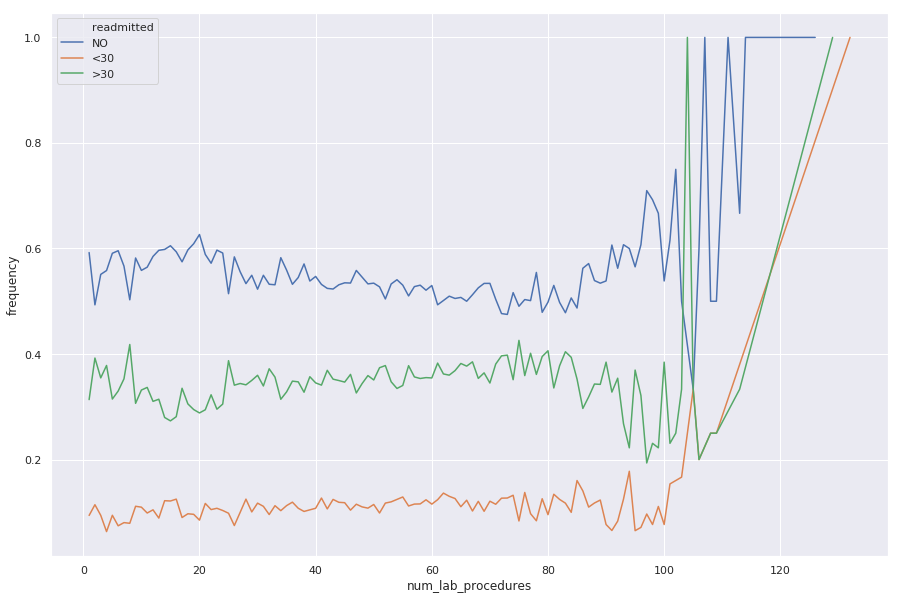

In [14]:
by_num_lab_procedures = frequencies_by_groups(df, ['num_lab_procedures', 'readmitted'], df_labels)
plt.figure(figsize=(15, 10))
sns.lineplot(x = 'num_lab_procedures', 
             y='frequency', 
             hue='readmitted', 
             data=by_num_lab_procedures)

Indeed after 100 lab procedures we see a sharp increase in the frequency of readmissions.

In [15]:
by_num_lab_procedures.loc[by_num_lab_procedures.readmitted == '<30', :].sort_values(by=['num_lab_procedures'], ascending=False).head(10)

,num_lab_procedures,readmitted,value_count,sum_by_num_lab_procedures,frequency
331,132,<30,1,1,1.000000
320,109,<30,1,4,0.250000
317,108,<30,1,4,0.250000
313,106,<30,1,5,0.200000
310,105,<30,2,6,0.333333
306,103,<30,1,6,0.166667
301,101,<30,2,13,0.153846
298,100,<30,1,13,0.076923
295,99,<30,1,9,0.111111
292,98,<30,2,26,0.076923


What are the top primary diagnoses among the readmitted patients? Are the top primary diagnoses different for patients from other `readmitted` categories?

In [16]:
by_diag1 = frequencies_by_groups(df, ['diag_1', 'readmitted'], df_labels)
by_diag1.head()

,diag_1,readmitted,value_count,sum_by_diag_1,frequency
0,NaN,NO,12,21,0.571429
1,NaN,<30,5,21,0.238095
2,NaN,>30,4,21,0.190476
3,10,NO,1,1,1.000000
4,11,NO,7,10,0.700000


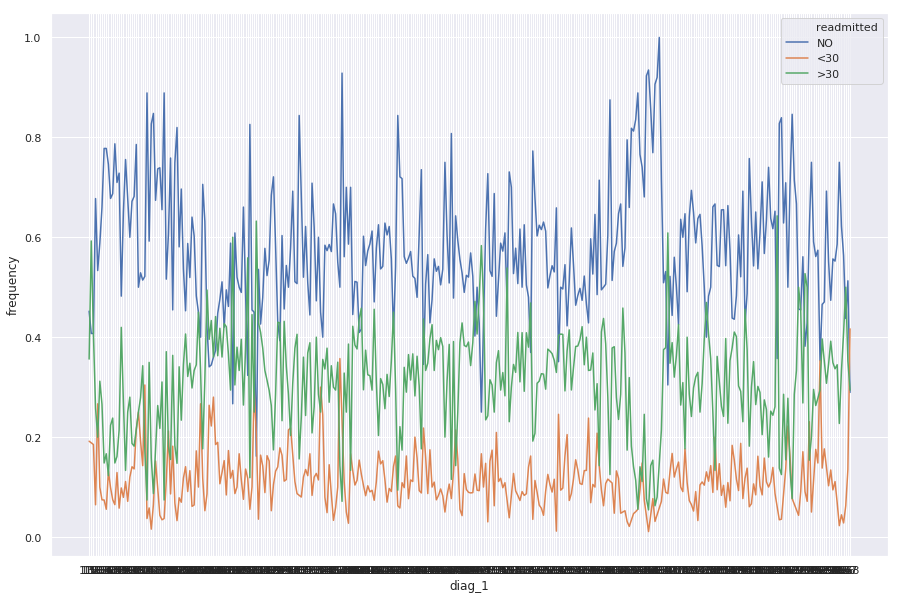

In [17]:
plt.figure(figsize=(15, 10))
sns.lineplot(x = 'diag_1', 
             y='frequency', 
             hue='readmitted', 
             data=by_diag1.loc[by_diag1.sum_by_diag_1 > 12, ['diag_1', 'readmitted', 'frequency']])

In [18]:
by_diag1_box = by_diag1.loc[by_diag1.sum_by_diag_1 > 12, :]
by_diag1_box = by_diag1_box.pivot(index='diag_1', columns='readmitted', values='frequency')
by_diag1_box.head()

readmitted,<30,>30,NO
diag_1,,,
NaN,0.238095,0.190476,0.571429
112,0.191781,0.356164,0.452055
135,NaN,0.592593,0.407407
150,0.185185,0.407407,0.407407
151,0.064516,0.258065,0.677419


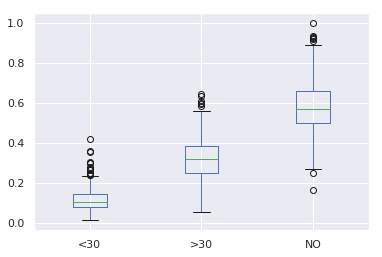

In [19]:
by_diag1_box.plot.box()

In [20]:
tree = ICD9('icd9/codes.json')
def simplify_codes(codes):
    """Takes a series of codes, simplifies and pads them with zeros to be useful for searching in ICD9 database
    Args:
        codes: a Series of ICD9 codes in extended format
    Returns:
        List containing simplified and padded ICD9 codes. The order corresponds to the codes in the argument.
    """
    pat = '^([EV]?\\d\\d?\\d?\\.?\\d?).?'
    short_pat = '^(\\d*)'
    simple_codes = [re.search(pat, code).group(1) if type(code) == str else np.nan for code in codes]
    simple_codes_padded = [('0' * (3 - len(re.search(short_pat , code).group(1))) + code) if (type(code)==str and bool(re.search(short_pat , code).group())) else code for code in simple_codes]
    return simple_codes_padded

def find_description(code):
    try:
        int(code)
        if int(code) in range(910, 920):
            return tree.find('905').description
        elif int(code) == 235:
            return tree.find('236').description
        elif int(code) == 752:
            return tree.find('751').description
        else:
            return tree.find(code).description
    except ValueError:
       return tree.find(code).description

In [21]:
top_diag1_readmitted_shortly = by_diag1.loc[np.logical_and(
    by_diag1.readmitted == '<30',
    by_diag1.value_count>12), :].sort_values('frequency', ascending=False).head(20)
top_diag1_readmitted_shortly['description'] = [find_description(code) for code in simplify_codes(top_diag1_readmitted_shortly.diag_1)]
top_diag1_readmitted_shortly[['diag_1', 'frequency', 'value_count', 'description']]

,diag_1,frequency,value_count,description
1684,V58,0.416667,95,Encounter for other and unspecified procedures...
274,250.41,0.263736,24,Diabetes with renal manifestations
970,567,0.245614,14,Peritonitis and retroperitoneal infections
277,250.42,0.222222,20,Diabetes with renal manifestations
415,298,0.218750,14,Other nonorganic psychoses
716,443,0.218182,24,Other peripheral vascular disease
1038,593,0.207921,21,Other disorders of kidney and ureter
367,282,0.205882,14,Hereditary hemolytic anemias
986,572,0.205021,49,Liver abscess and sequelae of chronic liver di...
704,438,0.200000,17,Late effects of cerebrovascular disease


In [22]:
top_diag1_readmitted_longer = by_diag1.loc[np.logical_and(
    by_diag1.readmitted == '>30',
    by_diag1.value_count>12), :].sort_values('frequency', ascending=False).head(20)
top_diag1_readmitted_longer['description'] = [tree.find(code).description for code in simplify_codes(top_diag1_readmitted_longer.diag_1)]
top_diag1_readmitted_longer[['diag_1', 'frequency', 'value_count', 'description']]

,diag_1,frequency,value_count,description
368,282,0.632353,43,Hereditary hemolytic anemias
1190,693,0.608696,14,Dermatitis due to substances taken internally
18,135,0.592593,16,Sarcoidosis
826,494,0.583333,14,Bronchiectasis
354,277,0.558824,19,Other and unspecified disorders of metabolism
878,522,0.538462,14,Diseases of pulp and periapical tissues
1552,924,0.527273,29,Contusion of lower limb and of other and unspe...
1527,9,0.500000,23,Ill-defined intestinal infections
272,250.4,0.494382,132,Diabetes with renal manifestations
823,493,0.479167,506,Asthma


In [23]:
top_diag1_not_readmitted = by_diag1.loc[np.logical_and(
    by_diag1.readmitted == 'NO',
    by_diag1.value_count>12), :].sort_values('frequency', ascending=False).head(20)
top_diag1_not_readmitted['description'] = [find_description(code) for code in simplify_codes(top_diag1_not_readmitted.diag_1)]
top_diag1_not_readmitted[['diag_1', 'frequency', 'value_count', 'description']]

,diag_1,frequency,value_count,description
1162,664,1.000000,20,Trauma to perineum and vulva during delivery
1140,654,0.934783,86,Abnormality of organs and soft tissues of pelvis
570,378,0.928571,13,Strabismus and other disorders of binocular ey...
1158,661,0.920000,23,Abnormality of forces of labor
1150,659,0.906250,29,Other indications for care or intervention rel...
195,235,0.888889,24,Neoplasm of uncertain behavior of genitourinar...
1106,627,0.888889,16,Menopausal and postmenopausal disorders
149,205,0.888889,24,Myeloid leukemia
1057,601,0.875000,14,Inflammatory diseases of prostate
1144,656,0.857143,18,Other known or suspected fetal and placental p...


In [24]:
by_simple_diag_1 = frequencies_by_groups(df, ['simple_diag_1', 'readmitted'], df_labels)
top_simple_diag_1_readmitted_shortly = by_simple_diag_1.loc[np.logical_and(
    by_simple_diag_1.readmitted == '<30',
    by_simple_diag_1.value_count>12), :].sort_values('frequency', ascending=False).head(20)
top_simple_diag_1_readmitted_shortly['description'] = [find_description(code) for code in simplify_codes(top_simple_diag_1_readmitted_shortly.simple_diag_1)]
top_simple_diag_1_readmitted_shortly[['simple_diag_1', 'frequency', 'value_count', 'description']]

,simple_diag_1,frequency,value_count,description
1622,V58,0.416667,95,Encounter for other and unspecified procedures...
942,567,0.245614,14,Peritonitis and retroperitoneal infections
426,298,0.218750,14,Other nonorganic psychoses
705,443,0.218182,24,Other peripheral vascular disease
1008,593,0.207921,21,Other disorders of kidney and ureter
378,282,0.205882,14,Hereditary hemolytic anemias
957,572,0.205021,49,Liver abscess and sequelae of chronic liver di...
693,438,0.200000,17,Late effects of cerebrovascular disease
218,202,0.192308,20,Other malignant neoplasms of lymphoid and hist...
86,112,0.191781,14,Candidiasis


In [25]:
by_level_4_diag_1 = frequencies_by_groups(df, ['level_4_diag_1', 'readmitted'], df_labels)
top_level_4_diag_1_readmitted_shortly = by_level_4_diag_1.loc[np.logical_and(
    by_level_4_diag_1.readmitted == '<30',
    by_level_4_diag_1.value_count>12), :].sort_values('frequency', ascending=False).head(20)
top_level_4_diag_1_readmitted_shortly['description'] = [find_description(code) for code in simplify_codes(top_level_4_diag_1_readmitted_shortly.level_4_diag_1)]
top_level_4_diag_1_readmitted_shortly[['level_4_diag_1', 'frequency', 'value_count', 'description']]

,level_4_diag_1,frequency,value_count,description
1585,V58,0.416667,95,Encounter for other and unspecified procedures...
913,567,0.245614,14,Peritonitis and retroperitoneal infections
397,298,0.218750,14,Other nonorganic psychoses
676,443,0.218182,24,Other peripheral vascular disease
979,593,0.207921,21,Other disorders of kidney and ureter
349,282,0.205882,14,Hereditary hemolytic anemias
928,572,0.205021,49,Liver abscess and sequelae of chronic liver di...
664,438,0.200000,17,Late effects of cerebrovascular disease
218,202,0.192308,20,Other malignant neoplasms of lymphoid and hist...
86,112,0.191781,14,Candidiasis


In [26]:
by_level_3_diag_1 = frequencies_by_groups(df, ['level_3_diag_1', 'readmitted'], df_labels)
top_level_3_diag_1_readmitted_shortly = by_level_3_diag_1.loc[np.logical_and(
    by_level_3_diag_1.readmitted == '<30',
    by_level_3_diag_1.value_count>12), :].sort_values('frequency', ascending=False).head(20)
top_level_3_diag_1_readmitted_shortly['description'] = [find_description(code) for code in simplify_codes(top_level_3_diag_1_readmitted_shortly.level_3_diag_1)]
top_level_3_diag_1_readmitted_shortly[['level_3_diag_1', 'frequency', 'value_count', 'description']]

,level_3_diag_1,frequency,value_count,description
360,V58,0.416667,95,Encounter for other and unspecified procedures...
90,282,0.205882,14,Hereditary hemolytic anemias
57,200-208,0.180995,40,Lymphosarcoma and reticulosarcoma and other sp...
325,960-979,0.170455,45,Poisoning by antibiotics
279,790-796,0.164021,31,Nonspecific findings on examination of blood
135,350-359,0.163934,20,Trigeminal nerve disorders
105,287,0.162791,14,Purpura and other hemorrhagic conditions
34,110-118,0.160920,14,Dermatophytosis
246,700-709,0.158621,46,Corns and callosities
163,440-449,0.155425,212,Atherosclerosis


In [27]:
by_level_2_diag_1 = frequencies_by_groups(df, ['level_2_diag_1', 'readmitted'], df_labels)
top_level_2_diag_1_readmitted_shortly = by_level_2_diag_1.loc[np.logical_and(
    by_level_2_diag_1.readmitted == '<30',
    by_level_2_diag_1.value_count>12), :].sort_values('frequency', ascending=False).head(20)
top_level_2_diag_1_readmitted_shortly['description'] = [find_description(code) for code in simplify_codes(top_level_2_diag_1_readmitted_shortly.level_2_diag_1)]
top_level_2_diag_1_readmitted_shortly[['level_2_diag_1', 'frequency', 'value_count', 'description']]

,level_2_diag_1,frequency,value_count,description
58,V50-V59,0.163772,264,Elective surgery for purposes other than remed...
13,280-289,0.134180,148,Iron deficiency anemias
10,240-279,0.127847,1465,Simple and unspecified goiter
49,800-999,0.122455,854,Fracture of vault of skull
16,290-319,0.122016,276,Dementias
4,001-139,0.114523,317,Cholera
22,390-459,0.114517,3474,Rheumatic fever without mention of heart invol...
31,580-629,0.108113,549,Acute glomerulonephritis
25,460-519,0.106851,1112,Acute nasopharyngitis [common cold]
28,520-579,0.104909,966,Disorders of tooth development and eruption


It is clear that the top primary diagnoses are strikingly different for 3 categories of `readmitted` variable (readmitted within 30 days, readmitted after 30 days, not readmitted). Also the grouppings of diagnosis at different levels showed different distributions across the readmitted groups. Generally speaking the top frequencies of primary diagnoses of patients readmitted within 30 days generally decreased with higher level of groupping. This property could be useful during machine learning of classification since different levels of diagnosis grouppings could capture different aspects useful for prediction.

Are there any linear relationships that exist between the numerical variables and their frequencies in the group of patients readmitted within 30 days?

/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


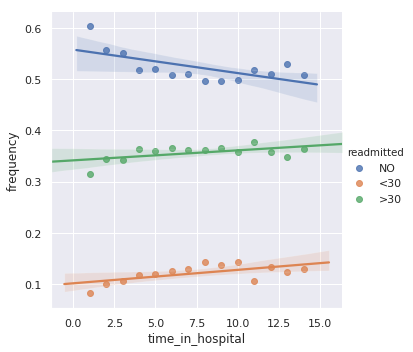

In [28]:
by_time_in_hospital = frequencies_by_groups(df, ['time_in_hospital', 'readmitted'], df_labels)
sns.lmplot(x='time_in_hospital', y='frequency', hue='readmitted', data=by_time_in_hospital)

/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


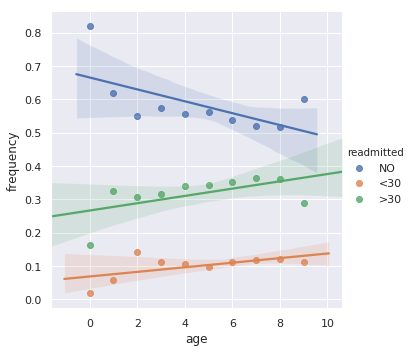

In [29]:
by_age = frequencies_by_groups(df, ['age', 'readmitted'], df_labels)
age_cat_type = CategoricalDtype(categories=['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', 
                                                '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'],
                                ordered=True)
by_age.age = by_age.age.astype(age_cat_type)
by_age['age'] = by_age.age.cat.codes
sns.lmplot(x='age', y='frequency', hue='readmitted', data=by_age)

/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


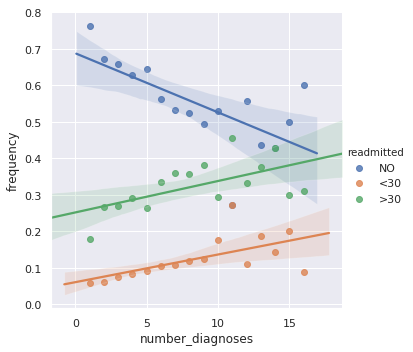

In [30]:
by_number_diagnoses = frequencies_by_groups(df, ['number_diagnoses', 'readmitted'], df_labels)
sns.lmplot(x='number_diagnoses', y='frequency', hue='readmitted', data=by_number_diagnoses)

/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


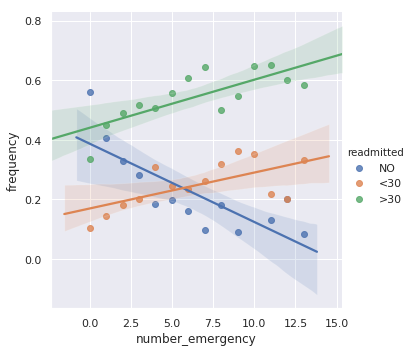

In [31]:
by_number_emergency = frequencies_by_groups(df, ['number_emergency', 'readmitted'], df_labels)
sns.lmplot(x='number_emergency', y='frequency', hue='readmitted', data=by_number_emergency.loc[by_number_emergency.number_emergency < 14])

/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


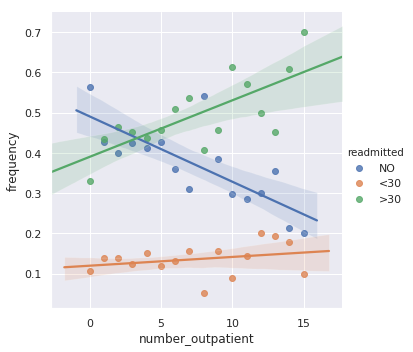

In [32]:
by_number_outpatient = frequencies_by_groups(df, ['number_outpatient', 'readmitted'], df_labels)
sns.lmplot(x='number_outpatient', y='frequency', hue='readmitted', data=by_number_outpatient.loc[by_number_outpatient.number_outpatient < 16])

The analysis showed that there is a positive relationship of the frequency of patients who were readmitted within 30 days with the following variables: 1) number of days in the hospital, 2) age, 3) number of diagnoses, 4) number of emergency visits in a year preceding the encounter, 5) Number of outpatient visits in a year preceding the encounter. The frequencies of all these variables showed negative slope  for the category without readmission. It appears that these categories could be very important for the classification.

Are there independent variables that show correlation?

/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


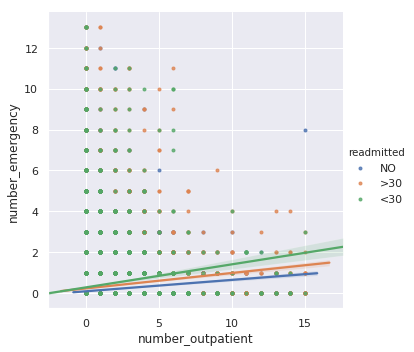

In [33]:
filtered_out_em_df = df.loc[(df.number_outpatient < 16) & (df.number_emergency < 14)].copy()
filtered_out_em_df.readmitted = [df_labels['readmitted'][x]for x in filtered_out_em_df.readmitted]
sns.lmplot(x='number_outpatient', y='number_emergency', data=filtered_out_em_df, markers='.', hue='readmitted')

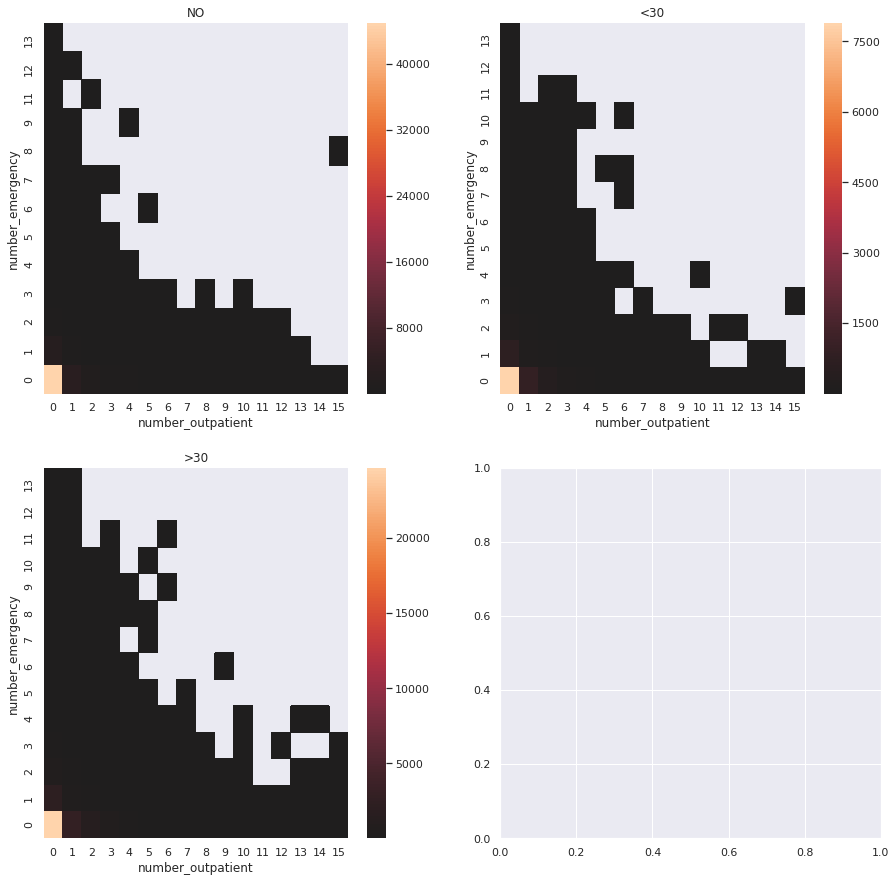

In [34]:
def heatmaps_by_readmitted(filtered_df, groups, df_labels):
    readm_cat = df_labels['readmitted']
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
    for i, categ in enumerate(readm_cat):
        temp_df = filtered_df.loc[(filtered_df.readmitted == categ), groups + ['readmitted']].groupby(groups + ['readmitted']).size()
        temp_df.name = 'count'
        temp_df = temp_df.reset_index()
        temp_df = temp_df.pivot(index=groups[0], columns=groups[1], values='count')
        temp_df = temp_df.sort_index(ascending=False)
        #temp_df = temp_df.loc[4:, :6]
        if categ == 'NO':
            cur_axis = ax[0, 0]
        elif categ == '<30':
            cur_axis = ax[0, 1]
        else:
            cur_axis = ax[1, 0]
        sns.heatmap(temp_df,
            ax=cur_axis,
            center=0)#,
            #cmap=sns.dark_palette("palegreen", as_cmap=True))
        cur_axis.set_title(categ)
heatmaps_by_readmitted(filtered_out_em_df, ['number_emergency', 'number_outpatient'], df_labels)

/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


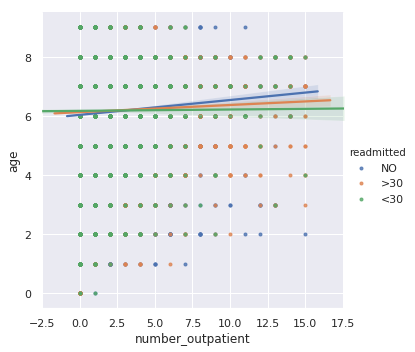

In [35]:
filtered_out_age_df = df.loc[df.number_outpatient < 16].copy()
filtered_out_age_df.readmitted = [df_labels['readmitted'][x]for x in filtered_out_age_df.readmitted]
sns.lmplot(x='number_outpatient', y='age', data=filtered_out_age_df, markers='.', hue='readmitted')

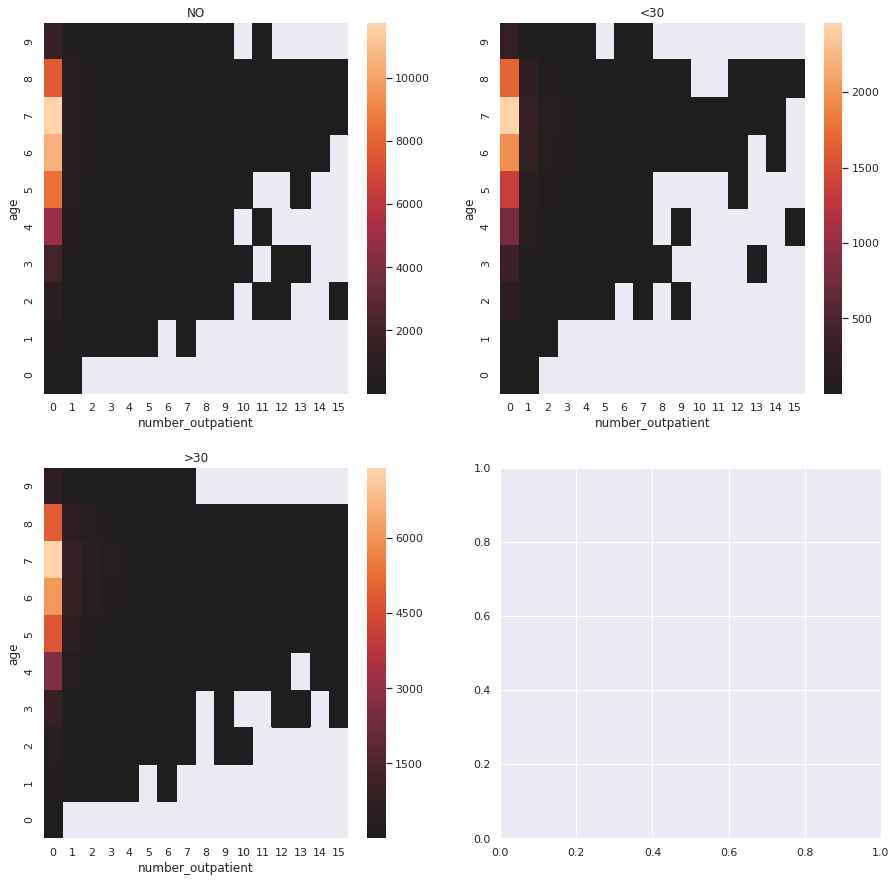

In [36]:
heatmaps_by_readmitted(filtered_out_age_df, ['age', 'number_outpatient'], df_labels)

/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


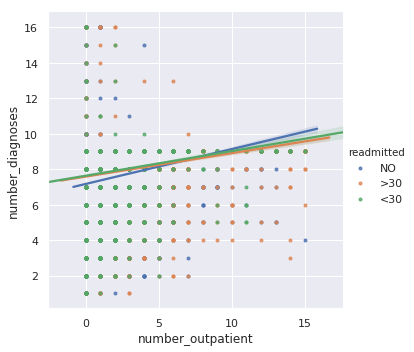

In [37]:
filtered_out_diag_df = df.loc[df.number_outpatient < 16].copy()
filtered_out_diag_df.readmitted = [df_labels['readmitted'][x]for x in filtered_out_diag_df.readmitted]
sns.lmplot(x='number_outpatient', y='number_diagnoses', data=filtered_out_diag_df, markers='.', hue='readmitted')

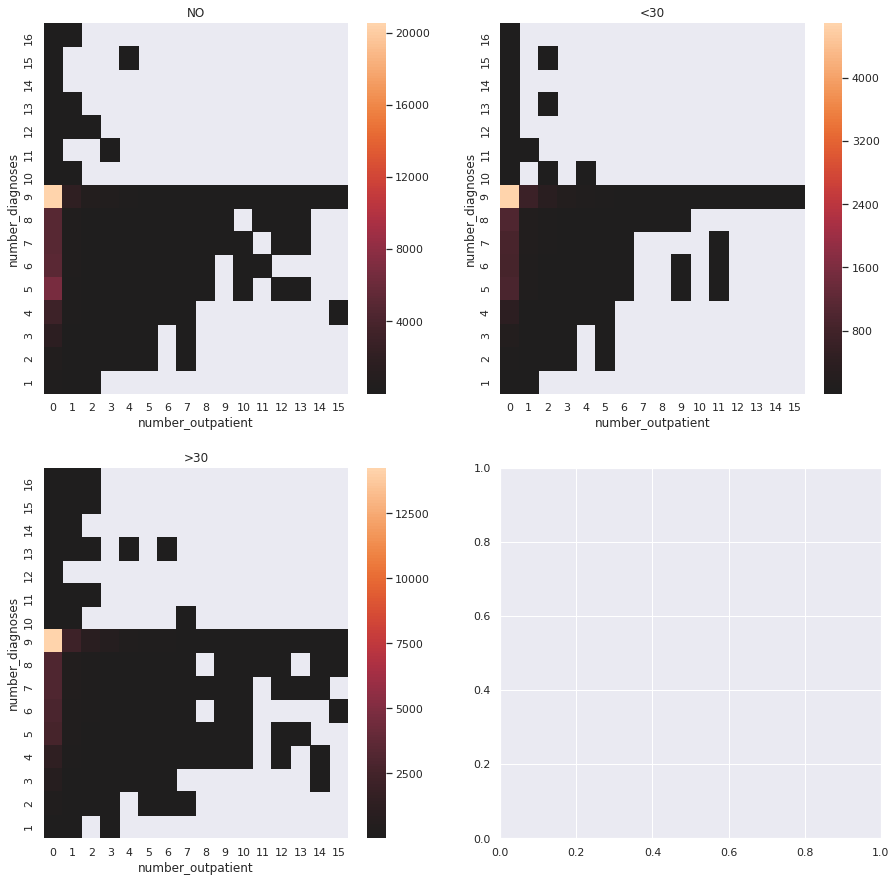

In [38]:
heatmaps_by_readmitted(filtered_out_diag_df, ['number_diagnoses', 'number_outpatient'], df_labels)